<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Александр Кацалап (ODS Slack nick: Alexkats)
    
## <center> Prediction of real estate prices at Melbourne housing market

In this project I will analyze **Melbourne Housing Market** data, collected by [Tony Pino](https://www.kaggle.com/anthonypino) and posted on [Kaggle](https://www.kaggle.com/anthonypino/melbourne-housing-market/home).

This data was scraped from publicly available results posted every week from real estate resource [Domain.com.au](https://www.domain.com.au). Dataset includes address, type of real estate, suburb, method of selling, rooms, price, real estate agent, date of sale and distance from C.B.D. - centre of Melbourne.

The purpose of this project is building a model, that will allow to predict the price of property on Melbourne house market, based on its characteristics. **So, our task is regression task.**

It may be useful to know actual property price in next cases:

- You are ***property seller*** and you want to sell it as soon as possible. You don't want to sell it at a low price and lose your money. And you don't want to find during long time you buyer because of too high price of the property.


- You are ***property buyer*** and you want to buy a good house for a good price and don't want to overpay.


- You are **real estate agency** like a [Domain.com.au](https://www.domain.com.au) and you want to remove  advertisements with suspicious objects on your website. For example, if sale advertisement have very low price in compare with objects with aproximatly same characteristics, it may be a fraud. Prediction of actual prices will help to detect and remove such advertisement and **you don't lose your customers**.
	



### Part 1. Dataset and features description

Dataset contains information about property sales in Melbourne during the period **from January, 2016 to October, 2018.**

Let's load dataset and describe given features:

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
warnings.simplefilter("ignore")

In [5]:
full_data = pd.read_csv('Melbourne_housing_FULL.csv', parse_dates=['Date'])
full_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,2016-03-09,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,2016-04-02,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [6]:
full_data = full_data[full_data['Date'] <= '2018-04-01']

Every object in dataset (every row) is a sold of property with its own characteristics and additional information as seller, sell type and sell.

Let's get info about types of columns and skipped values in dataset:

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33561 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           33561 non-null object
Address          33561 non-null object
Rooms            33561 non-null int64
Type             33561 non-null object
Price            26218 non-null float64
Method           33561 non-null object
SellerG          33561 non-null object
Date             33561 non-null datetime64[ns]
Distance         33561 non-null float64
Postcode         33561 non-null float64
Bedroom2         25752 non-null float64
Bathroom         25743 non-null float64
Car              25286 non-null float64
Landsize         22461 non-null float64
BuildingArea     13316 non-null float64
YearBuilt        15079 non-null float64
CouncilArea      33559 non-null object
Lattitude        25986 non-null float64
Longtitude       25986 non-null float64
Regionname       33559 non-null object
Propertycount    33559 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), obj

As we see, data contains 21 columns, many of them have missing values.

### 1.1 Features description

Let's give a more detailed description about columns meaning:

**Suburb**: Suburb name in Melbourne

**Address**: Address

**Rooms**: Number of rooms

**Bedroom2**: Number of rooms (from different source)

**Price**: Price in Australian dollars. It's a ***target value*** in our task

**Method** -  type of sales method:
- S  - property sold; 
- SP - property sold prior; 
- PI - property passed in; 
- PN - sold prior not disclosed; 
- SN - sold not disclosed; 
- VB - vendor bid; 
- W  - withdrawn prior to auction; 
- SA - sold after auction; 
- SS - sold after auction price not disclosed. 

**Type** -  type of property:
- h - house, cottage, villa, semi, terrace; 
- u - unit, duplex; 
- t - townhouse; 


**SellerG**: Real Estate Agent

**Date**: Date sold

**Distance**: Distance from C.B.D.(Melbourne centre) in Kilometres

**Regionname**: General Region (West, North West, North, North east ...etc.)

**Propertycount**: Number of properties that exist in the suburb.

**Bathroom**: Number of Bathrooms

**Car**: Number of carspots

**Landsize**: Land size in Metres

**BuildingArea**: Building size in Metres

**YearBuilt**: Year the house was built

**CouncilArea**: Governing council for the area

**Lattitude**: Lattitude coordinate of property

**Longtitude**: Longtitude coordinate of property

From this description it's possible to classify most of these features into categorical and numeric (continiuos):

***Categorical features:***
- Suburb, Type, Method, SellerG, Postcode, CouncilArea, Regionname

***Numeric features:***
- Rooms, Date, Distance, Bedroom2, Bathroom, Car, Landsize, BuildingArea, YearBuilt, Lattitude, Longtitude,Propertycount

***Target value:***
- Price

Also there are some complex features, that ***can't be definitely classified*** by them type and must be transformed before used in modeling:

- Address, Postcode

### Part 2. Exploratory data analysis

As we see, that there are missing values in our target. The reason is that **Method** of selling theese properties was among **PN, SS**. Theese methods didn't imply diclosing sell price. So we shall have to remove such objects from dataset when we will build our model. But before it we save them for calculating some statistics and for missing values imputing.

Let's separate dataset into 2 parts: with target value and without target value:

And split data with not missing target into feature data and target data:

In [8]:
X_full = full_data.copy()
y_full = full_data['Price']

### 2.1  Features interactions and their influence on the target

Let's explain features influence on the target variable - **Price**. 

1. It's evident, that features **Rooms,  Bedroom2, Bathroom, Car, Landsize, BuildingArea**  are directly proportional to house price. Therefore, it is expected that they should have a high correlation with target.
 
2. **Date** of sold probably will have seasonal influence on price: for example, there is low season at summer and high season at winter. 
 
3. **Distance** from CBD may have complex, non-linear influence on price. On the one hand, the price should be the highest in the center and should decrease when moving to the outskirts. On the other hand, in the centre of big city there is a bad ecology and very noisy. 
  
4. Similar reasoning can be done for the **YearBuilt** of construction. On the one hand, the price should be the highest for the new buildings and houses. On the other hand, very old buildings may be architectural monuments and have historical value, so very old buildings may have very high prices.
 
5. Features **Suburb, Postcode, Regionname** characterize houses locations in the city, and, as consequences, crime situation and transport accessibility. So, theese features and their different combinations should influence on the house price.

6. **CouncilArea** may characterize the quality of local goverment work. The degree of well-being is depends on this work and, as consequence, depend a house prices in different areas.

7. **Type** of property certainly matters, because own cottage or villa is more expensive, than duplex with neighbors.

### 2.2 Target value analysis

Save target value  **Price** without NaNs to variable $y$ for analysis:

In [9]:
y = full_data[full_data.Price.notnull()]['Price']

Let's plot the distribution of target value:

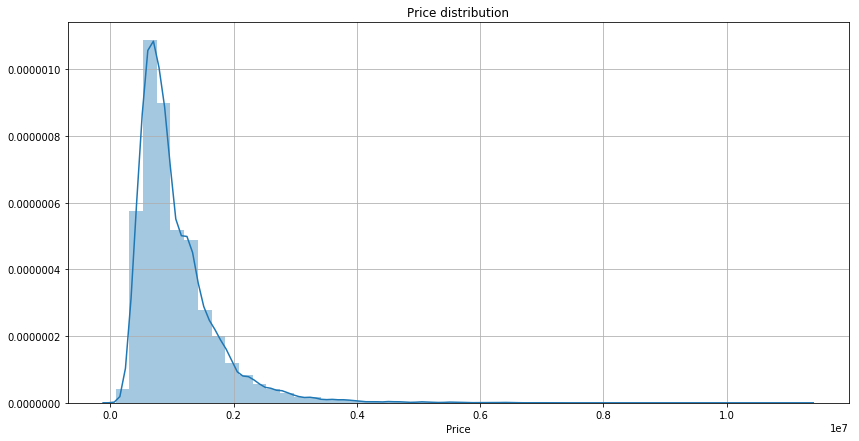

In [10]:
plt.figure(figsize=(14, 7))
sns.distplot(y)
plt.grid()
plt.title('Price distribution');

It is not a nornal distribution, so it is not a good idea to predict this value directly. So we try to take a **logarithm of target** and plot the distribution of such transformed value:

$$ \widehat{y} = ln (y + 1) $$

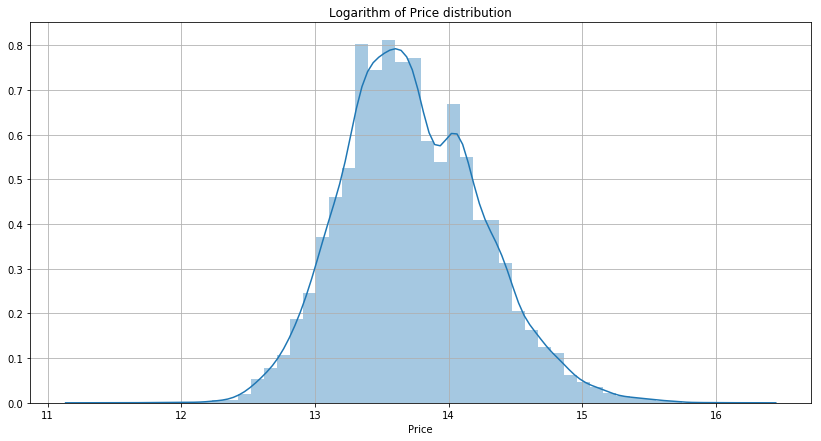

In [11]:
plt.figure(figsize=(14, 7))
sns.distplot(np.log( 1.0 + y ))
plt.grid()
plt.title('Logarithm of Price distribution');

So let's make a statistical tests for normality and skewness of distribution of $\widehat{y} $ . 

Use the **Shapiro-Wilk and Kolmogorov-Smirnov nornality tests**:

In [12]:
from scipy.stats import shapiro, kstest, probplot, skew
test_stat, p_value = shapiro(np.log(y))
test_stat, p_value

(0.993354856967926, 2.062829485851938e-32)

In [13]:
test_stat, p_value = kstest(np.log(y), cdf='norm')
test_stat, p_value

(1.0, 0.0)

**QQ-plot of $\widehat{y}$**. 

For ideal normal distribution all blue dots lay on red line.

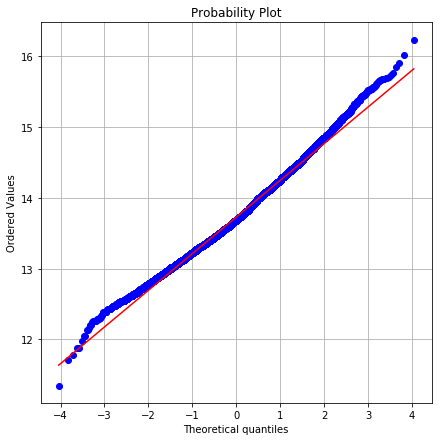

In [14]:
plt.figure(figsize=(7,7))
probplot(np.log(y), dist='norm', plot=plt);
plt.grid()

**Skewness** test. For symmetrical distribution result of skewness test is equal to zero.

In [15]:
skew(np.log(y))

0.32664952595735286

Nevertheless distribution of $\widehat{y}$ is slightly non symmetrical, QQ-plot and both  normality tests passed **allow us to work with value $\widehat{y}$ as with normal distributed value.**

So, we shall work with target value $y$ as follows:

1. Train models on transform target $y^* = ln(y+1)$ 
2. Make a prediction as $\widehat{y}_*$ 
3. Perform the inverse transform to original target: $\widehat{y} = e^{\widehat{y}_*} - 1$ 
4. Check their quality by calculating some metric $f(y, \widehat{y})$, that will be choosed later.

### 2.3   Missing values processing

Because of a lot of missings in data, first of all, we shall try to fill them.

In [16]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33561 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           33561 non-null object
Address          33561 non-null object
Rooms            33561 non-null int64
Type             33561 non-null object
Price            26218 non-null float64
Method           33561 non-null object
SellerG          33561 non-null object
Date             33561 non-null datetime64[ns]
Distance         33561 non-null float64
Postcode         33561 non-null float64
Bedroom2         25752 non-null float64
Bathroom         25743 non-null float64
Car              25286 non-null float64
Landsize         22461 non-null float64
BuildingArea     13316 non-null float64
YearBuilt        15079 non-null float64
CouncilArea      33559 non-null object
Lattitude        25986 non-null float64
Longtitude       25986 non-null float64
Regionname       33559 non-null object
Propertycount    33559 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), obj

Fill fields Regionname, Propertycount, CouncilArea, Postcode. 

Let's look at object with Postcode missed:

In [17]:
X_full[X_full.Postcode.isnull()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount


The most fields are missing, so it's better to drop this object:

In [18]:
X_full = X_full[~X_full.Postcode.isnull()]

In [19]:
X_full.Postcode = X_full.Postcode.astype(int)

For objects with missed Regionname, Propertycount, CouncilArea we get the same case: the most of fields are missing, so we drop them too:

In [20]:
X_full[X_full.Regionname.isnull()]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
18523,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,2017-07-15,5.1,3011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26888,Camberwell,2/3 Kingsley St,2,h,825000.0,VB,Jellis,2017-11-11,7.7,3124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
X_full = X_full[~X_full.Regionname.isnull()]

Check missing values count in data again:

In [22]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33559 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           33559 non-null object
Address          33559 non-null object
Rooms            33559 non-null int64
Type             33559 non-null object
Price            26216 non-null float64
Method           33559 non-null object
SellerG          33559 non-null object
Date             33559 non-null datetime64[ns]
Distance         33559 non-null float64
Postcode         33559 non-null int64
Bedroom2         25752 non-null float64
Bathroom         25743 non-null float64
Car              25286 non-null float64
Landsize         22461 non-null float64
BuildingArea     13316 non-null float64
YearBuilt        15079 non-null float64
CouncilArea      33559 non-null object
Lattitude        25986 non-null float64
Longtitude       25986 non-null float64
Regionname       33559 non-null object
Propertycount    33559 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(2), objec

Check YearBuilt values. Plot histogram:

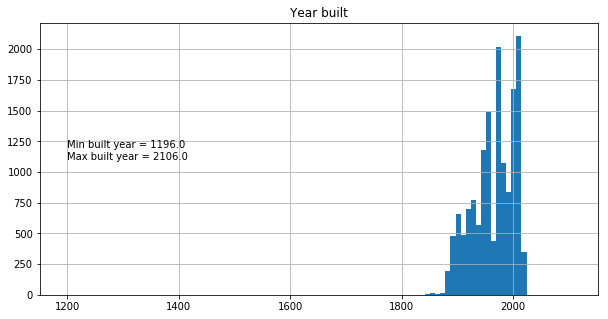

In [23]:
plt.figure(figsize=(10,5))
X_full.YearBuilt.hist(bins=100)

plt.text(x=1200, y = 1200, s='Min built year = {}'.format(X_full.YearBuilt.min()))
plt.text(x=1200, y = 1100, s='Max built year = {}'.format(X_full.YearBuilt.max()))
plt.title('Year built');

There are wrong values, including values from future:)

Set them to NaN, and then fill together with other missings.

In [24]:
X_full[(X_full.YearBuilt < 1800) | (X_full.YearBuilt > 2018)]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2453,Bulleen,3 Maringa St,4,h,NaN,SP,Ray,2016-07-11,11.8,3105,...,2.0,2.0,729.0,255.0,2106.0,Manningham City Council,-37.76370,145.08810,Eastern Metropolitan,4480.0
16424,Mount Waverley,5 Armstrong St,3,h,1200000.0,VB,McGrath,2017-06-24,14.2,3149,...,1.0,4.0,807.0,117.0,1196.0,Monash City Council,-37.86788,145.12121,Eastern Metropolitan,13366.0
33033,Bentleigh,1 Wyuna Ct,3,h,1100000.0,VB,Woodards,2018-03-17,11.4,3204,...,1.0,4.0,635.0,242.0,2019.0,Glen Eira City Council,-37.92963,145.03666,Southern Metropolitan,6795.0


In [25]:
X_full.loc[(X_full.YearBuilt < 1800) | (X_full.YearBuilt > 2018), 'YearBuilt'] = np.nan

Note, that there are a lot of Lattitude and Longtitude missing values. But we can restore them by Adress (using street), PostCode, RegionName, Suburb and CouncilArea values. 

Select objects with filled Lattitude and Longtitude, and find mean values for them by grouping by theese values:

In [26]:
coords_features = ['Address', 'Postcode', 'Regionname', 'Suburb', 'CouncilArea', 'Lattitude', 'Longtitude']

In [27]:
coords_data = X_full[~((X_full.Lattitude.isnull()) & (X_full.Longtitude.isnull()))][coords_features]

In [28]:
coords_data.head()

,Address,Postcode,Regionname,Suburb,CouncilArea,Lattitude,Longtitude
0,68 Studley St,3067,Northern Metropolitan,Abbotsford,Yarra City Council,-37.8014,144.9958
1,85 Turner St,3067,Northern Metropolitan,Abbotsford,Yarra City Council,-37.7996,144.9984
2,25 Bloomburg St,3067,Northern Metropolitan,Abbotsford,Yarra City Council,-37.8079,144.9934
3,18/659 Victoria St,3067,Northern Metropolitan,Abbotsford,Yarra City Council,-37.8114,145.0116
4,5 Charles St,3067,Northern Metropolitan,Abbotsford,Yarra City Council,-37.8093,144.9944


Extraxt street name from address:

In [29]:
coords_data['Address_splitted'] = coords_data.Address.str.split(' ')
coords_data['Street'] = coords_data.Address_splitted.apply(lambda s: s[1])

In [30]:
group_features = ['Regionname','Suburb','CouncilArea']

In [31]:
coords_data_mean = coords_data\
                    .groupby(group_features)['Lattitude','Longtitude']\
                    .mean()\
                    .reset_index()\
                    .rename(columns={'Lattitude': 'Lat_new', 'Longtitude': 'Lon_new'})

In [32]:
coords_data_mean.head()

,Regionname,Suburb,CouncilArea,Lat_new,Lon_new
0,Eastern Metropolitan,Bayswater,Knox City Council,-37.848626,145.260982
1,Eastern Metropolitan,Bayswater North,Maroondah City Council,-37.825929,145.284352
2,Eastern Metropolitan,Bellfield,Banyule City Council,-37.752281,145.039601
3,Eastern Metropolitan,Blackburn,Whitehorse City Council,-37.821410,145.150006
4,Eastern Metropolitan,Blackburn North,Whitehorse City Council,-37.805467,145.153947


Now add Street name to our dataset and merge it with **coords_data_mean** :

In [33]:
X_full['Address_splitted'] = X_full.Address.str.split(' ')
X_full['Street'] = X_full.Address_splitted.apply(lambda s: s[1])
X_full['HouseNumber'] = X_full.Address_splitted.apply(lambda s: s[0])
X_full.drop('Address_splitted', axis=1, inplace=True)

In [34]:
X_full_2 = pd.merge(X_full, coords_data_mean, on=group_features, how='left')

In [35]:
X_full_2.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Street,HouseNumber,Lat_new,Lon_new
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,2016-03-09,2.5,3067,...,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0,Studley,68,-37.804113,144.997427
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-03-12,2.5,3067,...,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,Turner,85,-37.804113,144.997427
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067,...,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,Bloomburg,25,-37.804113,144.997427
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,2016-04-02,2.5,3067,...,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0,Victoria,18/659,-37.804113,144.997427
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067,...,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,Charles,5,-37.804113,144.997427


Now replace Nans in **Lattitude** and **Longtitude** by new values **Lat_new** and	**Lon_new**:

In [36]:
X_full_2.loc[X_full_2.Lattitude.isnull(), 'Lattitude'] = X_full_2['Lat_new']
X_full_2.loc[X_full_2.Longtitude.isnull(), 'Longtitude'] = X_full_2['Lon_new']

And check whether all NaNs in Lattitude and Longtitude are filled:

In [37]:
X_full_2[X_full_2.Lattitude.isnull()].shape[0]

89

No, there are 87 values unfilled, because there are some Regionname, Suburb and CouncilArea, when Lattitude and Longtitude values was missing totally. So, because count of such objects is very small compared to dataset size, we can just fill them by mean:

In [38]:
X_full_2.Lattitude = X_full_2.Lattitude.fillna(X_full_2.Lattitude.mean())
X_full_2.Longtitude = X_full_2.Longtitude.fillna(X_full_2.Longtitude.mean())

X_full_2.drop(['Lat_new','Lon_new'], axis=1, inplace=True)

Check missing values counts:

In [39]:
X_full_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33559 entries, 0 to 33558
Data columns (total 23 columns):
Suburb           33559 non-null object
Address          33559 non-null object
Rooms            33559 non-null int64
Type             33559 non-null object
Price            26216 non-null float64
Method           33559 non-null object
SellerG          33559 non-null object
Date             33559 non-null datetime64[ns]
Distance         33559 non-null float64
Postcode         33559 non-null int64
Bedroom2         25752 non-null float64
Bathroom         25743 non-null float64
Car              25286 non-null float64
Landsize         22461 non-null float64
BuildingArea     13316 non-null float64
YearBuilt        15076 non-null float64
CouncilArea      33559 non-null object
Lattitude        33559 non-null float64
Longtitude       33559 non-null float64
Regionname       33559 non-null object
Propertycount    33559 non-null float64
Street           33559 non-null object
HouseNumber     

So, we have missings in features: **Bedroom2, Bathroom, Car, Landsize, BuildingArea**

Before fill missing in them, let's check their distributions. They may have ouliers, that can have bad influence on filling quality and on model quality in futher.

Let's plot distributions of theese features:

1.0     12626
2.0     10611
3.0      2105
4.0       259
5.0        73
0.0        46
6.0        14
7.0         4
8.0         3
9.0         1
12.0        1
Name: Bathroom, dtype: int64

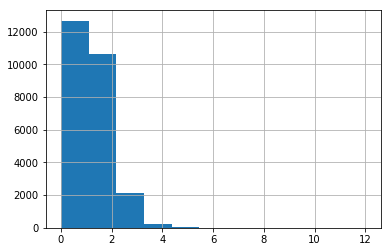

In [40]:
# Bathroom
X_full_2[~X_full_2.Bathroom.isnull()].Bathroom.hist(bins=11)
X_full_2[~X_full_2.Bathroom.isnull()].Bathroom.value_counts()

There are objects with 7 and more bathrooms! Let's look at them:

In [41]:
X_full[X_full.Bathroom >= 8][['Suburb', 'Address', 'Rooms', 'Type', 'Method',  'Date',
       'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Price']]

,Suburb,Address,Rooms,Type,Method,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Price
2536,Burwood,36 Cumming St,3,h,PI,2016-08-10,11.7,30.0,12.0,0.0,946.0,NaN,1950.0,NaN
8251,Preston,421 Murray Rd,4,h,PI,2016-05-22,8.8,9.0,8.0,7.0,1254.0,280.0,1928.0,760000.0
17472,Camberwell,1088 Toorak Rd,8,h,PI,2017-08-07,7.7,8.0,8.0,4.0,650.0,NaN,NaN,2200000.0
25717,Burwood,79 Elgar Rd,10,h,SP,2017-10-28,10.4,10.0,9.0,2.0,612.0,466.0,2015.0,2315000.0
26210,Mitcham,20 Harrison St,16,h,S,2017-10-28,17.2,16.0,8.0,8.0,NaN,NaN,NaN,5000000.0


3.0     11448
4.0      6063
2.0      5685
5.0      1364
1.0       964
6.0       156
7.0        29
0.0        17
8.0        13
9.0         5
10.0        4
30.0        1
20.0        1
12.0        1
16.0        1
Name: Bedroom2, dtype: int64

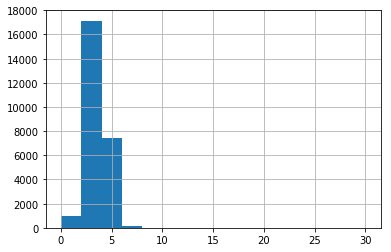

In [42]:
# Bedroom
X_full_2[~X_full_2.Bedroom2.isnull()].Bedroom2.hist(bins=15)
X_full_2[~X_full_2.Bedroom2.isnull()].Bedroom2.value_counts()

Is seems very suspicious, especially objects, when **bedrooms quantity is equals to bathrooms quantity :)**
The same for zero count of bedrooms.

So, it's better solution **to drop objects with bathrooms quantity more than 6 and with bedrooms quantity more than 8 (or equal to zero):**

In [43]:
X_full_3 = X_full_2[(X_full_2.Bathroom.isnull()) | (X_full_2.Bathroom <= 6)]
X_full_3 = X_full_3[(X_full_3.Bedroom2.isnull()) | ((X_full_3.Bedroom2 <= 8) & (X_full_3.Bedroom2 > 0))]

Check **Car** feature:

2.0     11715
1.0      8960
0.0      1598
3.0      1543
4.0      1104
5.0       143
6.0       133
7.0        22
8.0        21
10.0        5
9.0         3
11.0        2
18.0        1
26.0        1
12.0        1
Name: Car, dtype: int64

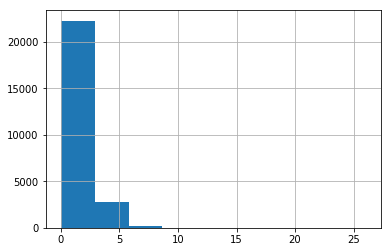

In [44]:
# Car
X_full_3[~X_full_3.Car.isnull()].Car.hist(bins=9)
X_full_3[~X_full_3.Car.isnull()].Car.value_counts()

In [45]:
X_full[X_full.Car > 9 ][['Suburb', 'Address', 'Rooms', 'Type', 'Method',  'Date',
       'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Price']].head()

,Suburb,Address,Rooms,Type,Method,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Price
4324,Fitzroy North,416 Queens Pde,5,h,S,2016-08-28,3.5,4.0,2.0,11.0,1010.0,440.0,NaN,NaN
6017,Kew,25 Duke St,2,h,S,2016-09-24,5.6,2.0,2.0,26.0,267.0,500.0,2011.0,NaN
15449,Bayswater,95 Orange Gr,4,h,SP,2017-06-17,23.2,4.0,1.0,10.0,993.0,128.0,1966.0,925000.0
18923,Dandenong,1462 Heatherton Rd,3,h,S,2017-07-22,24.7,3.0,2.0,10.0,734.0,NaN,NaN,880000.0
23395,Reservoir,1 Don St,4,h,S,2017-08-26,12.0,4.0,2.0,10.0,1002.0,170.0,1985.0,1112000.0


So, we see, that objects with carspots quantity more than 9 have very big Landsize values and suspiciously low prices. So, theese **objects aren't look like most others**, and we will drop them too:

In [46]:
X_full_3 = X_full_3[(X_full_3.Car.isnull()) | (X_full_3.Car < 9)]

Check **Landsize** feature:

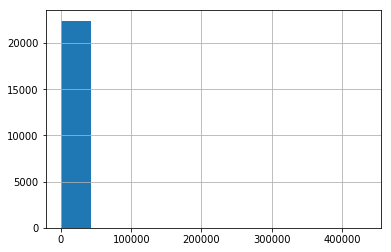

In [47]:
# Landsize
X_full_3[~X_full_3.Landsize.isnull()].Landsize.hist();

So, distribution is very skewed, because of outliers with very huge values. Let's find **mean value** and calculate **99.9% quantile for Landsize** feature. Also, find objects with top-10 Landsizes in our dataset:

In [48]:
# Find mean value of Landsize:
X_full_3.Landsize.mean()

589.8170666428763

In [49]:
# Find 99.9 % quantile of Landsize:
q_99 = X_full_3[~X_full_3.Landsize.isnull()].Landsize.quantile(0.999)
q_99

17200.0

In [50]:
# Find top-10 objects with biggest Landsize:
top_10_landsizes = sorted(X_full_3[~X_full_3.Landsize.isnull()].Landsize, reverse=True)[:10]

In [51]:
top_10_landsizes

[433014.0,
 146699.0,
 89030.0,
 80000.0,
 76000.0,
 75100.0,
 44500.0,
 42800.0,
 41400.0,
 40500.0]

In [52]:
X_full_3[X_full_3.Landsize.isin(top_10_landsizes)][['Suburb', 'Address', 'Rooms', 'Type', 'Method',  'Date',
       'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Price']]

,Suburb,Address,Rooms,Type,Method,Date,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Price
1198,Balwyn North,9 Gildan St,3,h,VB,2016-08-28,9.2,3.0,1.0,2.0,75100.0,NaN,NaN,2000000.0
8599,Reservoir,14 Beenak St,3,h,S,2016-04-23,11.2,3.0,1.0,2.0,41400.0,NaN,NaN,572000.0
17293,Silvan,16 Eleanor Dr,3,h,S,2017-05-27,34.6,3.0,2.0,2.0,76000.0,NaN,NaN,1085000.0
18036,Fitzroy,389 Gore St,3,h,VB,2017-12-08,2.1,3.0,3.0,1.0,433014.0,NaN,NaN,2700000.0
22631,New Gisborne,71 Hamilton Rd,5,h,S,2017-09-23,48.1,5.0,3.0,5.0,44500.0,44515.0,NaN,1355000.0
24799,Wildwood,430 Wildwood Rd,5,h,S,2017-10-14,31.7,5.0,2.0,2.0,89030.0,NaN,NaN,1030000.0
26867,Bullengarook,65 Webb Rd,4,h,PI,2017-11-11,45.9,4.0,2.0,1.0,146699.0,NaN,NaN,1050000.0
31090,Wandin North,237 Warburton Hwy,4,h,PI,2018-03-03,35.2,4.0,2.0,2.0,40500.0,NaN,NaN,1150000.0
31279,Diggers Rest,55 Morefield Ct,4,h,PI,2018-02-17,27.7,4.0,2.0,NaN,80000.0,NaN,NaN,NaN
32757,Bullengarook,11 Dohoney Rd,4,h,S,2018-02-24,45.9,4.0,2.0,0.0,42800.0,180.0,2000.0,865000.0


So, almost all of them are located far from CBD (mean distance is about 11 km). As with other outliers, we shall drop objects with Landsize more than 99.9%, because they will have bad influence on model quality:

In [53]:
X_full_3 = X_full_3[(X_full_3.Landsize.isnull()) | (X_full_3.Landsize < q_99)]

Plot the distribution after outliers removing:

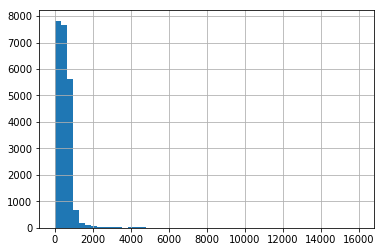

In [54]:
X_full_3[~X_full_3.Landsize.isnull()].Landsize.hist(bins=50);

Check **BuildingArea** feature:

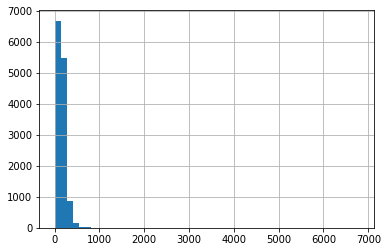

In [55]:
# Landsize
X_full_3[~X_full_3.BuildingArea.isnull()].BuildingArea.hist(bins=50);

We have the same situation  as with **Landsize**, so let's repeat the procedure for outliers dropping with **BuildingArea** feature:

In [56]:
# Find 99 % quantile of Landsize:
q_99 = X_full_3[~X_full_3.BuildingArea.isnull()].BuildingArea.quantile(0.99)
q_99

467.41999999999825

In [57]:
X_full_3 = X_full_3[(X_full_3.BuildingArea.isnull()) | (X_full_3.BuildingArea < q_99)]

Plot the distribution after outliers removing:

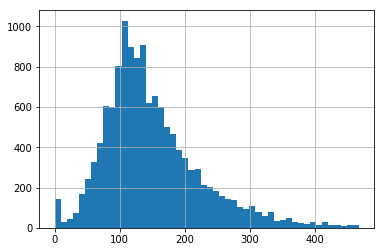

In [58]:
X_full_3[~X_full_3.BuildingArea.isnull()].BuildingArea.hist(bins=50);

Note, that BuildingArea can't be equal to zero! (unlike Landsize). But we have several zero values in BuildingArea feature. It seems to be mistake, so let's change theese zero values to NaNs:

In [59]:
X_full_3.loc[X_full_3.BuildingArea == 0, 'BuildingArea'] = np.nan

So, we dropped objects with abnormal values of several features. 

**I think, in real business task we just have to build others, separates models for every group of such objects. But in this task our goal is to build one model for most of objects in our dataset.**

In [60]:
X_full_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33352 entries, 0 to 33558
Data columns (total 23 columns):
Suburb           33352 non-null object
Address          33352 non-null object
Rooms            33352 non-null int64
Type             33352 non-null object
Price            26055 non-null float64
Method           33352 non-null object
SellerG          33352 non-null object
Date             33352 non-null datetime64[ns]
Distance         33352 non-null float64
Postcode         33352 non-null int64
Bedroom2         25545 non-null float64
Bathroom         25536 non-null float64
Car              25081 non-null float64
Landsize         22275 non-null float64
BuildingArea     13080 non-null float64
YearBuilt        14951 non-null float64
CouncilArea      33352 non-null object
Lattitude        33352 non-null float64
Longtitude       33352 non-null float64
Regionname       33352 non-null object
Propertycount    33352 non-null float64
Street           33352 non-null object
HouseNumber     

**It would be more correct to process NaNs in features like we did it with Lattitude and Longtitude by calculating mean values in groups with similar objects without NaNs and use those values to fill NaNs. **

But let't use **SimpleImputor** from Sklearn for saving time and variety :)

In [61]:
import sklearn
from sklearn.impute import SimpleImputer

In [62]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='median')

Select features for imputing:

In [63]:
features_with_nans = X_full_3.columns[X_full_3.isnull().any()].tolist()
features_with_nans.remove('Price')

In [64]:
X_full_3.reset_index(drop=True, inplace=True)
X_to_impute = X_full_3[features_with_nans].copy()

In [65]:
X_imputed_array = imputer_mean.fit_transform(X_to_impute)
X_imputed = pd.DataFrame(data=X_imputed_array, columns=features_with_nans)

Create new dataset with imputed values:

In [66]:
X_full_4 = pd.concat([X_full_3.drop(features_with_nans, axis=1), X_imputed], axis=1)

In [67]:
X_full_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33352 entries, 0 to 33351
Data columns (total 23 columns):
Suburb           33352 non-null object
Address          33352 non-null object
Rooms            33352 non-null int64
Type             33352 non-null object
Price            26055 non-null float64
Method           33352 non-null object
SellerG          33352 non-null object
Date             33352 non-null datetime64[ns]
Distance         33352 non-null float64
Postcode         33352 non-null int64
CouncilArea      33352 non-null object
Lattitude        33352 non-null float64
Longtitude       33352 non-null float64
Regionname       33352 non-null object
Propertycount    33352 non-null float64
Street           33352 non-null object
HouseNumber      33352 non-null object
Bedroom2         33352 non-null float64
Bathroom         33352 non-null float64
Car              33352 non-null float64
Landsize         33352 non-null float64
BuildingArea     33352 non-null float64
YearBuilt        

So, now there is no NaNs in our features values. 
**But there are NaNs in target value - Price**. 
Before building the model we will drop objects with missing targets.

Now let's split our data into features dataframe and target vector:

In [68]:
data_total = X_full_4.copy()

Add **Street** and **HouseNumber** again:

In [69]:
data_total['Address_splitted'] = data_total.Address.str.split(' ')
data_total['Street'] = data_total.Address_splitted.apply(lambda s: s[1])
data_total['HouseNumber'] = data_total.Address_splitted.apply(lambda s: s[0])
data_total.drop(['Address_splitted', 'Address'], axis=1, inplace=True)

In [70]:
data_total.YearBuilt = data_total.YearBuilt.astype(int)
data_total.Bedroom2 = data_total.Bedroom2.astype(int)
data_total.Bathroom = data_total.Bathroom.astype(int)
data_total.Car = data_total.Car.astype(int)

In [71]:
data = data_total[~data_total.Price.isnull()]

In [72]:
X_total = data_total.drop('Price', axis=1)

In [73]:
# Features for objects with price only
X = data_total[~data_total.Price.isnull()].drop('Price', axis=1)

In [74]:
# Target vector
y = data_total[~data_total.Price.isnull()]['Price']

Check shapes of dataframes:

In [75]:
X.shape, y.shape

((26055, 21), (26055,))

## Part 3. Visual analysis of the features

Let's split our features into **categical** and **numerical**:

In [76]:
numerical_features = ['Rooms','Distance', 'Propertycount', 
                      'Bedroom2', 'Bathroom', 'Car', 'Landsize', 
                      'BuildingArea', 'YearBuilt', 'HouseNumber']

In [77]:
cat_features = ['Suburb', 'Address','Type', 'Method', 'SellerG','CouncilArea','Regionname']

### 3.1 Numerical features relashonships

Let's use **seaborn pairplot** to visualize relationships between numerical features:

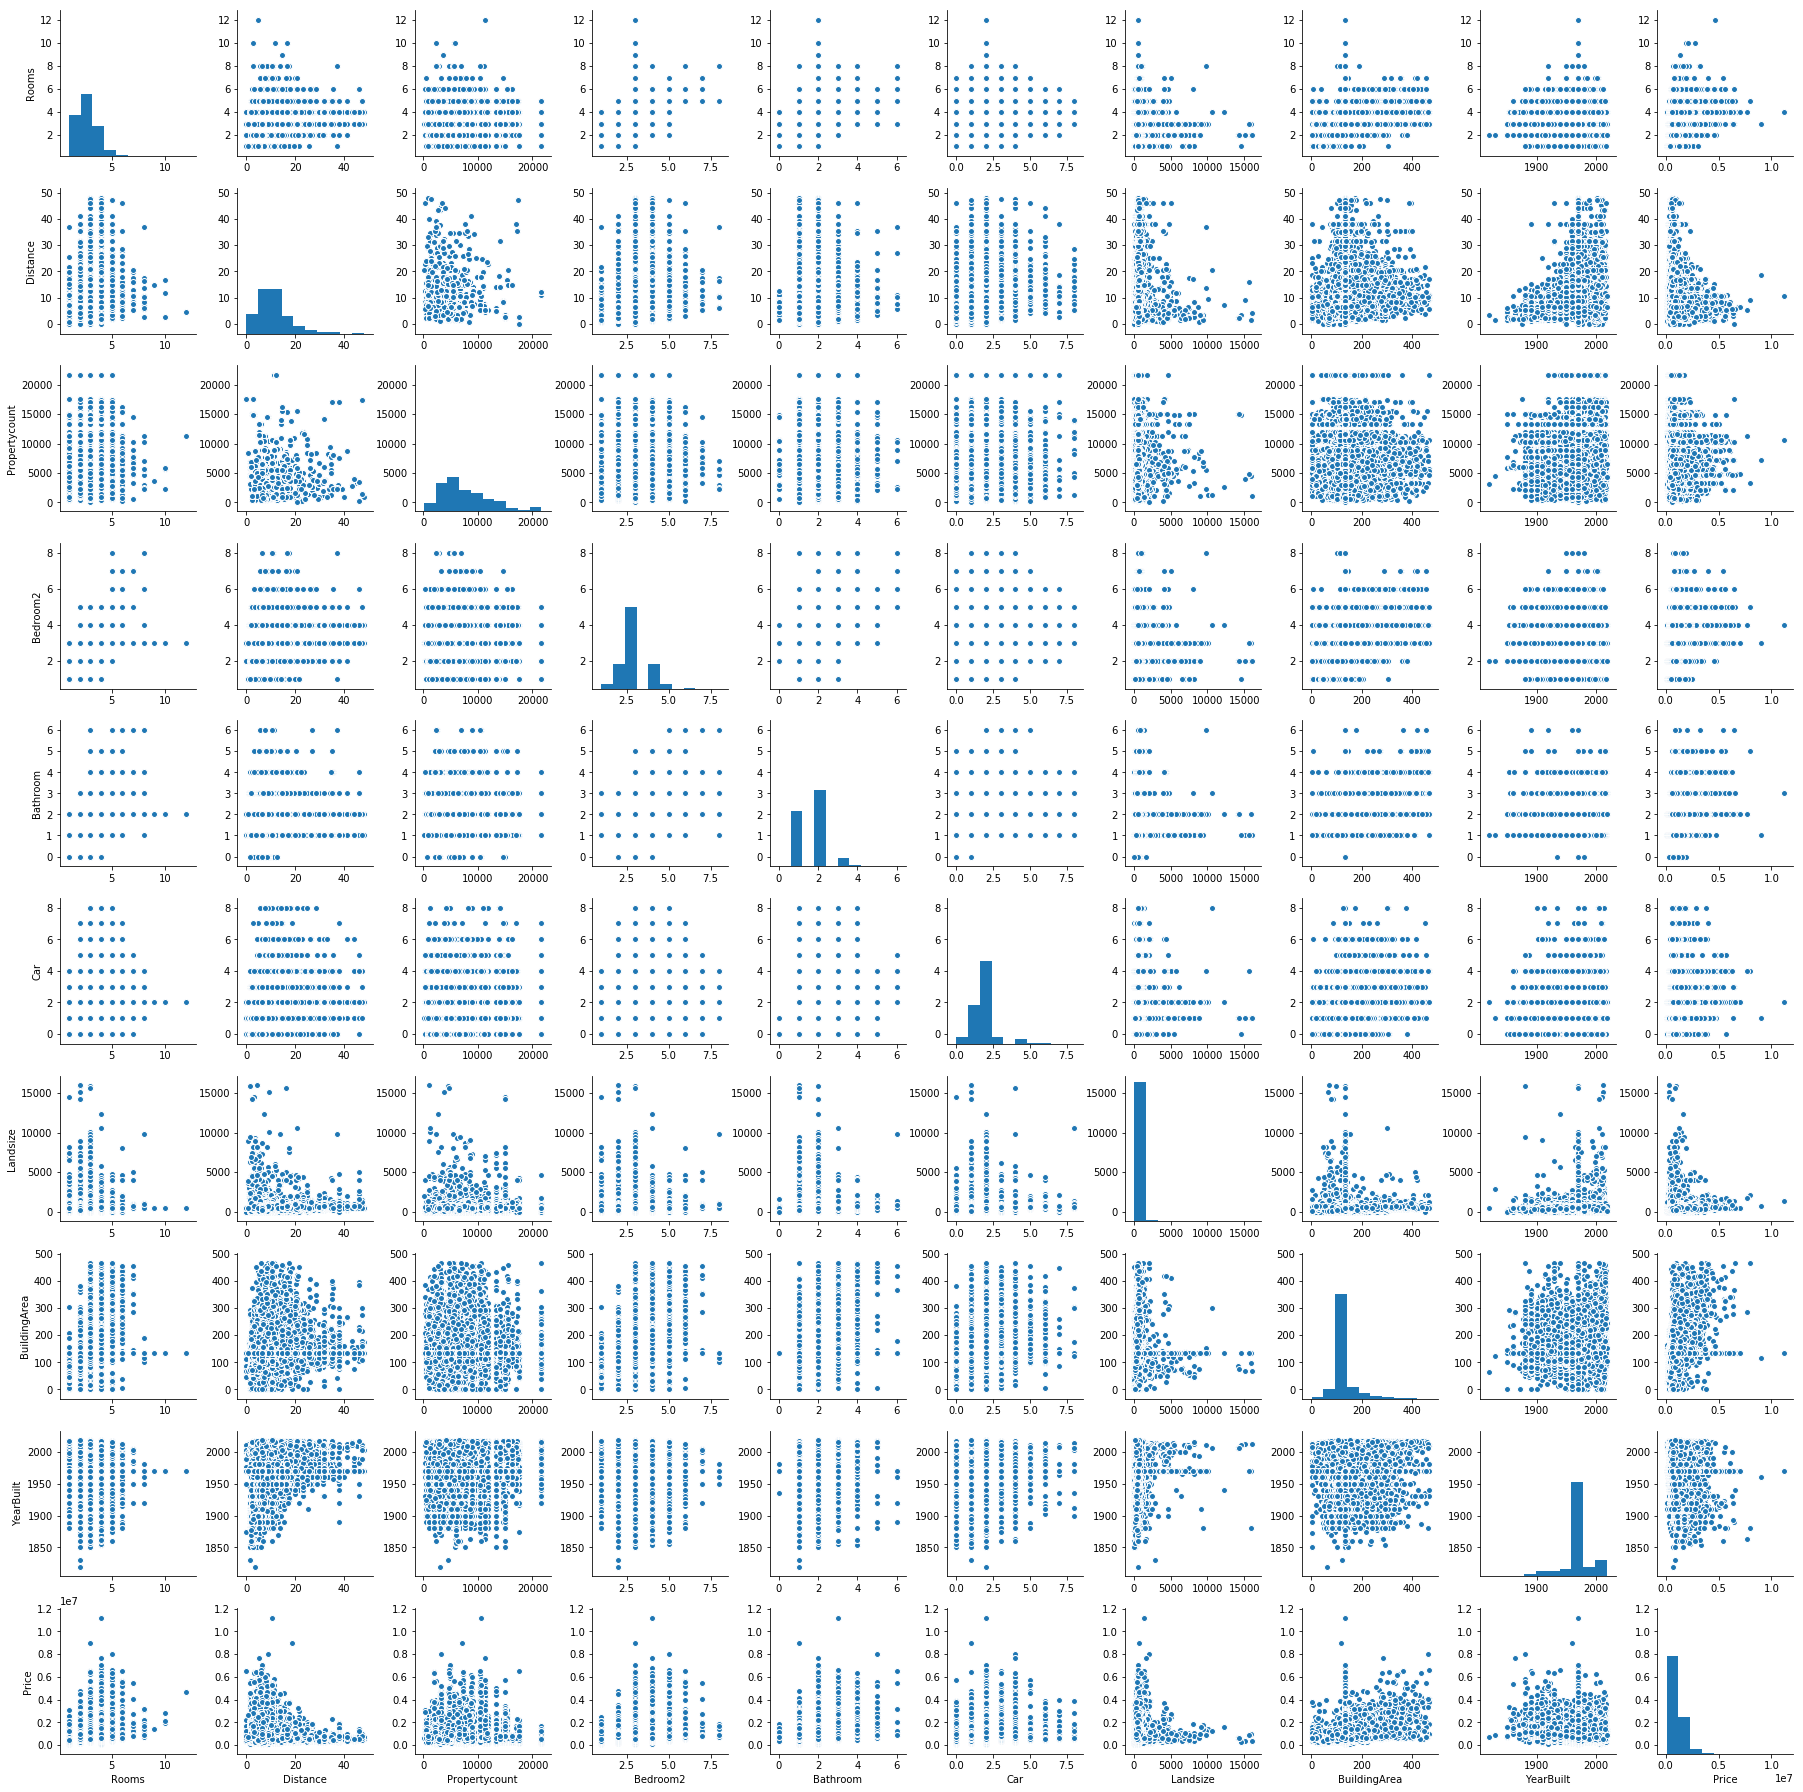

In [78]:
sns.pairplot(data=data[numerical_features + ['Price']]);

So, let's plot the most interesting of them seprately: 

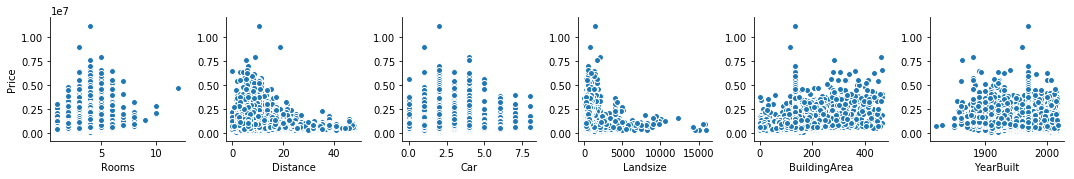

In [79]:
sns.pairplot(data=data[numerical_features + ['Price']], 
             y_vars=['Price'], 
             x_vars=['Rooms',  'Distance',
                     'Car', 'Landsize', 'BuildingArea', 'YearBuilt']);

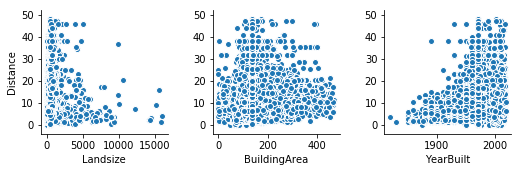

In [80]:
sns.pairplot(data=data[numerical_features + ['Price']], 
             y_vars=['Distance'], 
             x_vars=['Landsize', 'BuildingArea', 'YearBuilt']);

From theese plots we can just conclude, that price is inversely proportional to the distance from CBD. More older buildings are closer to CBD. And houses with bigger landsize are more far from CBD.

So, theese conclusions was expected and consistent with reality.

Let's plot **correlation matrix** for numerical features and target:

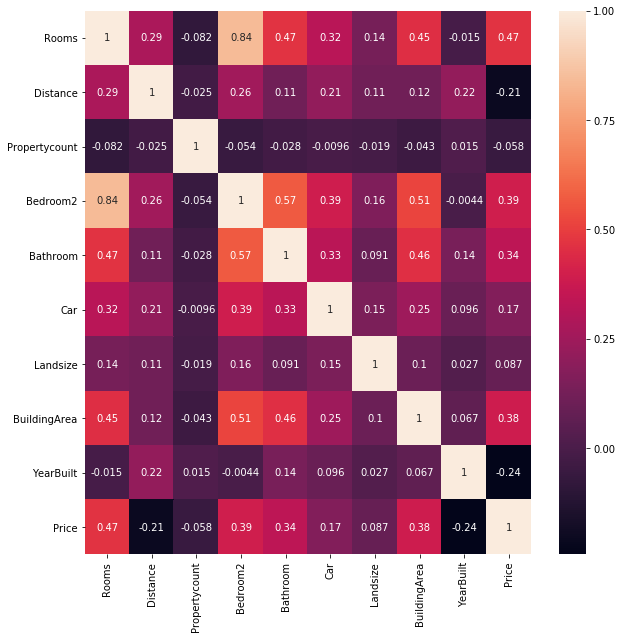

In [81]:
plt.figure(figsize=(10,10))
sns.heatmap(data[numerical_features + ['Price']].corr(), annot=True)

So, **Rooms, BuidingArea, Bedroom2, Bathroom, Car** are positive correlated with **Price** as expected.

Features like **YearBuilt** may have more complex dependencies with price, because they have different categorical features values (for exaple **Type** and **Regionname**). To check this hypothesis we have to analyze this and other muneric features in more detail. 

#### 3.2 Categorical features relashonships with target

I use **seaborn boxplot** to visualize price distributions in different groups of cat.features

Let's look, how prices are distributed depending on the **Type** feature:

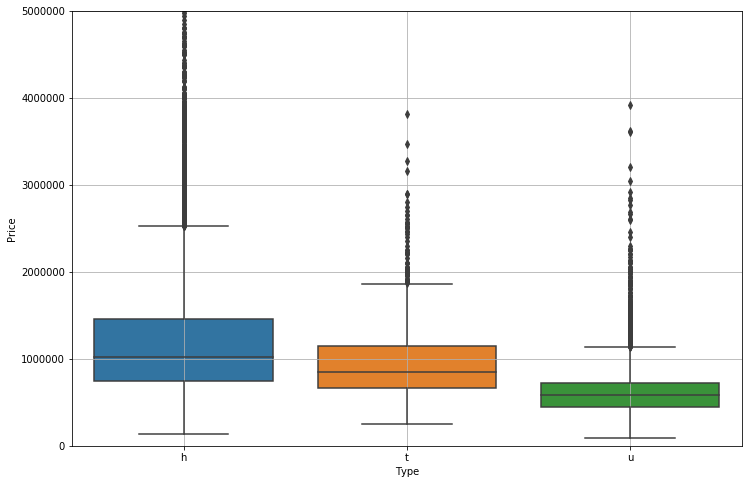

In [82]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Type', y='Price',
            data=data);
plt.ylim((0, 0.5*1e7))
plt.grid()
plt.show()

Same plot for **Regionname** feature:

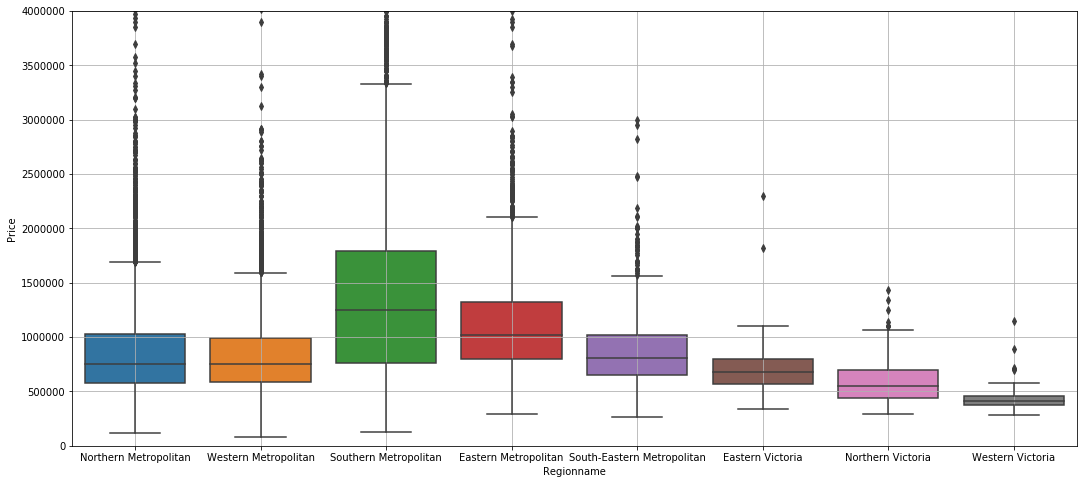

In [83]:
plt.figure(figsize=(18,8))

sns.boxplot(x='Regionname', y='Price',
            data=data);
plt.ylim((0, 0.4*1e7))
plt.grid()
plt.show()

Let's combine theese two plots to visualize price distributions, grouped by **Regionname** and **Type** simultaneously:

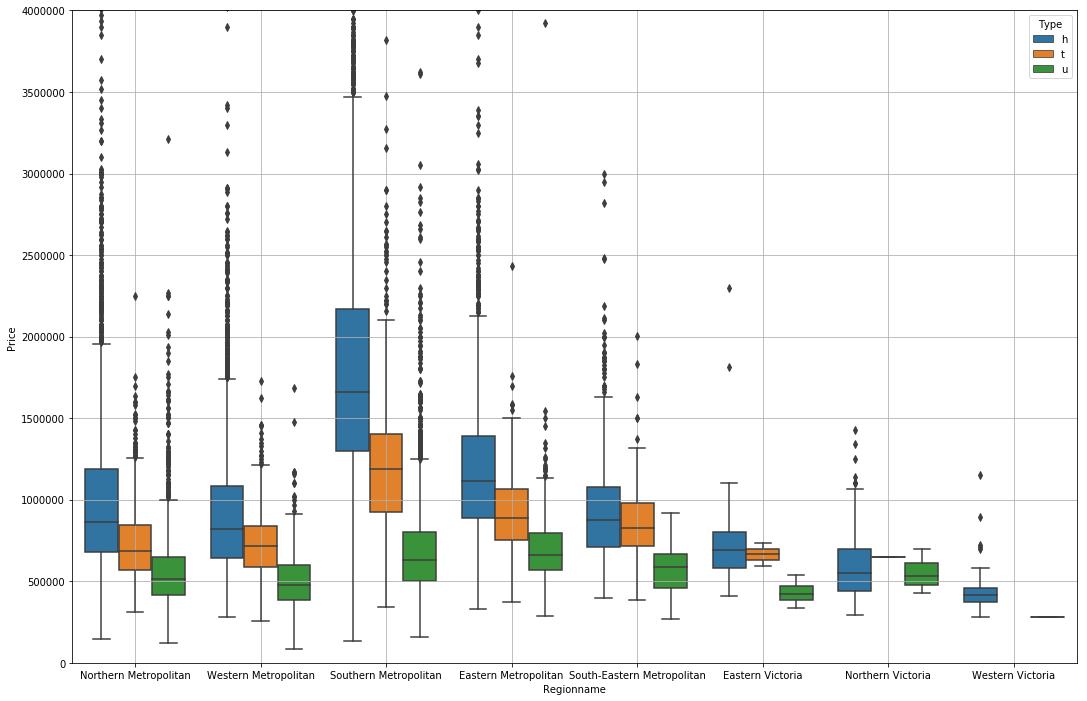

In [84]:
plt.figure(figsize=(18,12))

sns.boxplot(x='Regionname', y='Price',
            hue='Type',
            data=data);
plt.ylim((0, 0.4*1e7))
plt.grid()
plt.show()

And it's very interesting to plot the same for **Distance**:

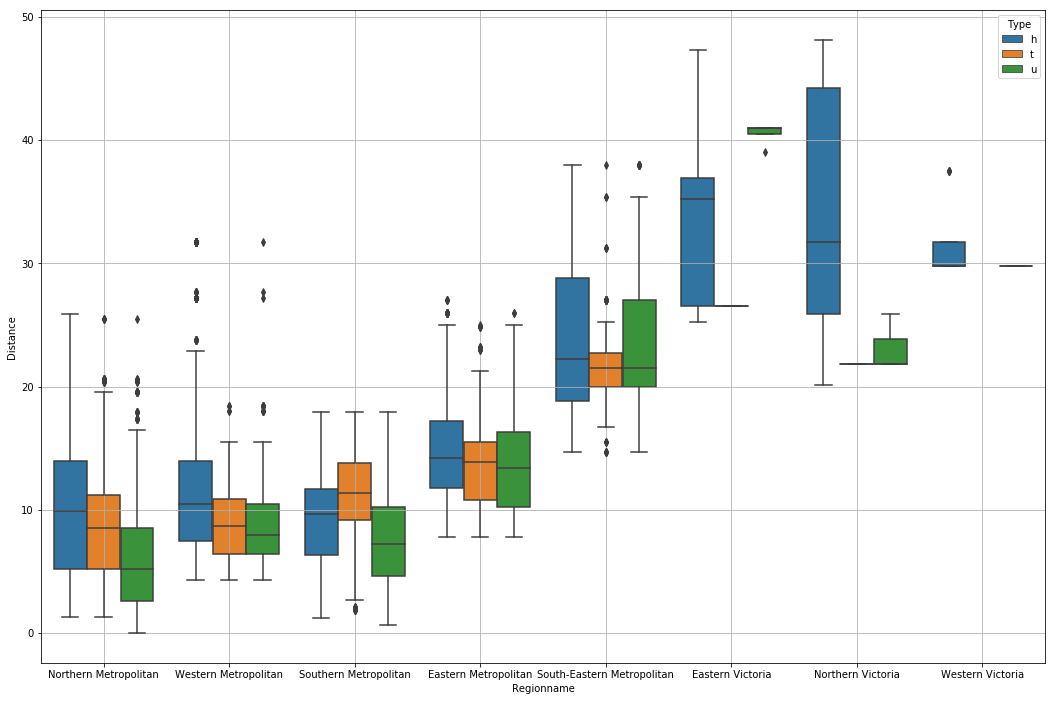

In [85]:
plt.figure(figsize=(18,12))

sns.boxplot(x='Regionname', y='Distance',
            hue='Type',
            data=data);
plt.grid()
plt.show()

Boxplot for **Price** with grouping by  **Council Area **:

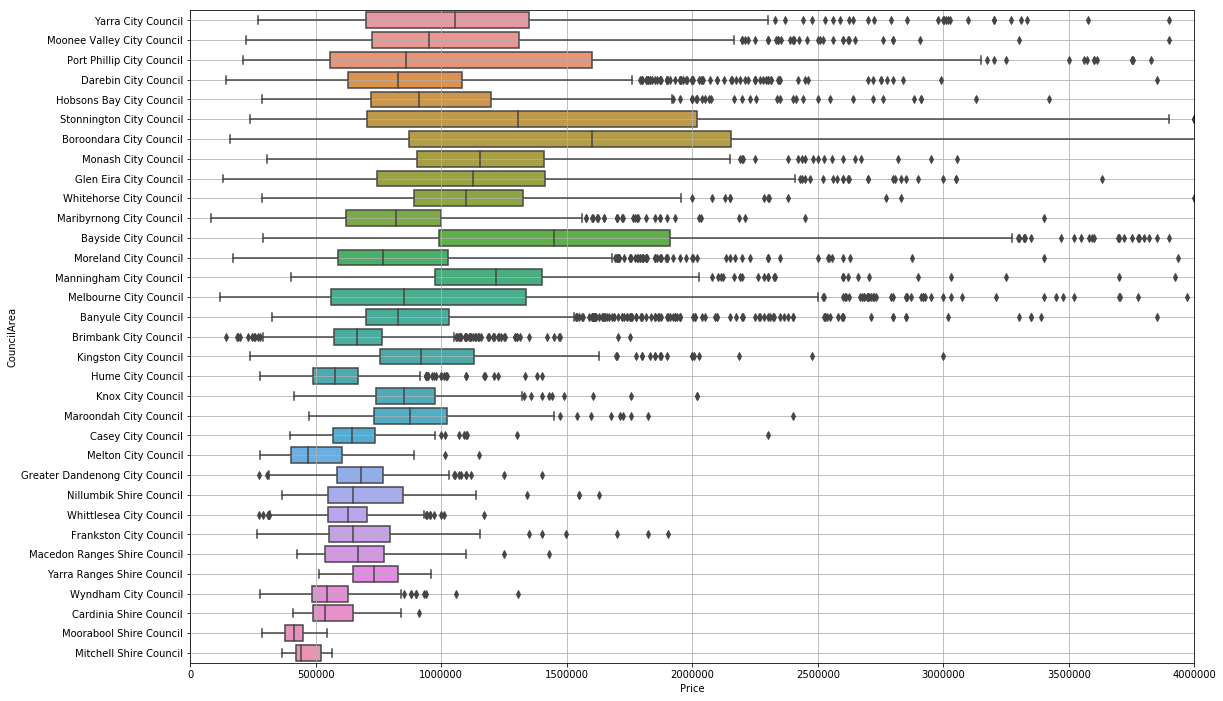

In [86]:
plt.figure(figsize=(18,12))
sns.boxplot(y='CouncilArea', x='Price', data=data);
plt.xlim((0, 0.4*1e7))
plt.grid()
plt.show()

Let's visualize price distributions, grouped by **Method** and **Type** simultaneously. It allows to understand influence of buying **Method** on the house price in every **Type**:

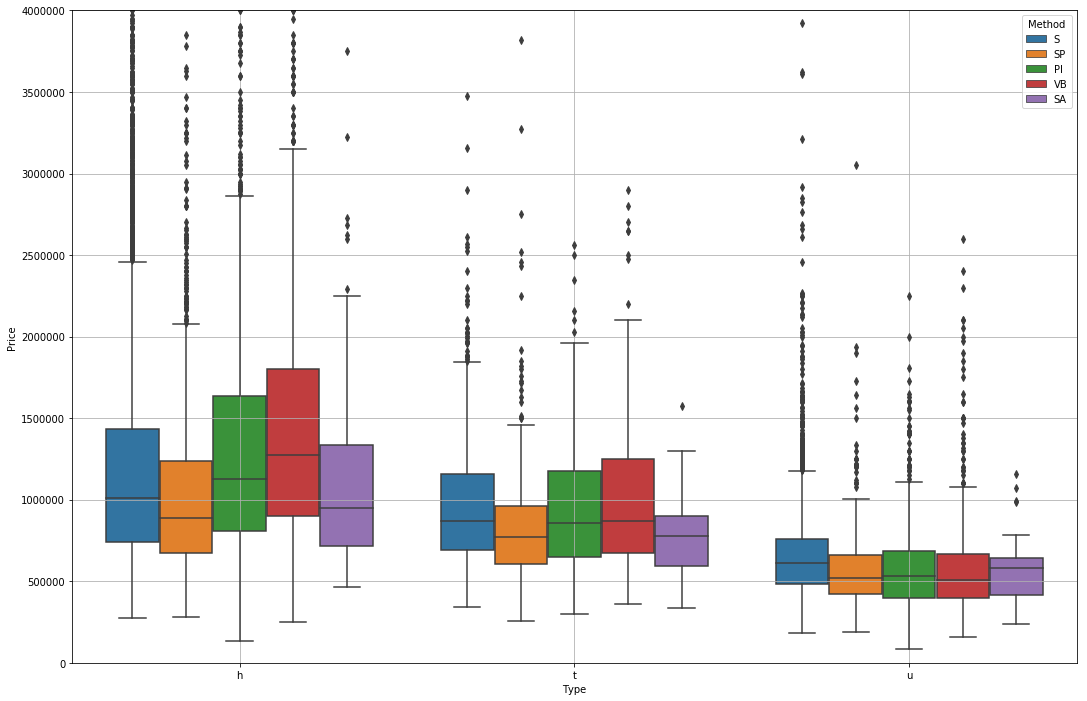

In [87]:
plt.figure(figsize=(18,12))

sns.boxplot(x='Type', y='Price',
            hue='Method',
            data=data);
plt.ylim((0, 0.4*1e7))
plt.grid()
plt.show()

To find out, how many objects contain different regions, how many objects was selled by different methods, let's drow  **countplots**:

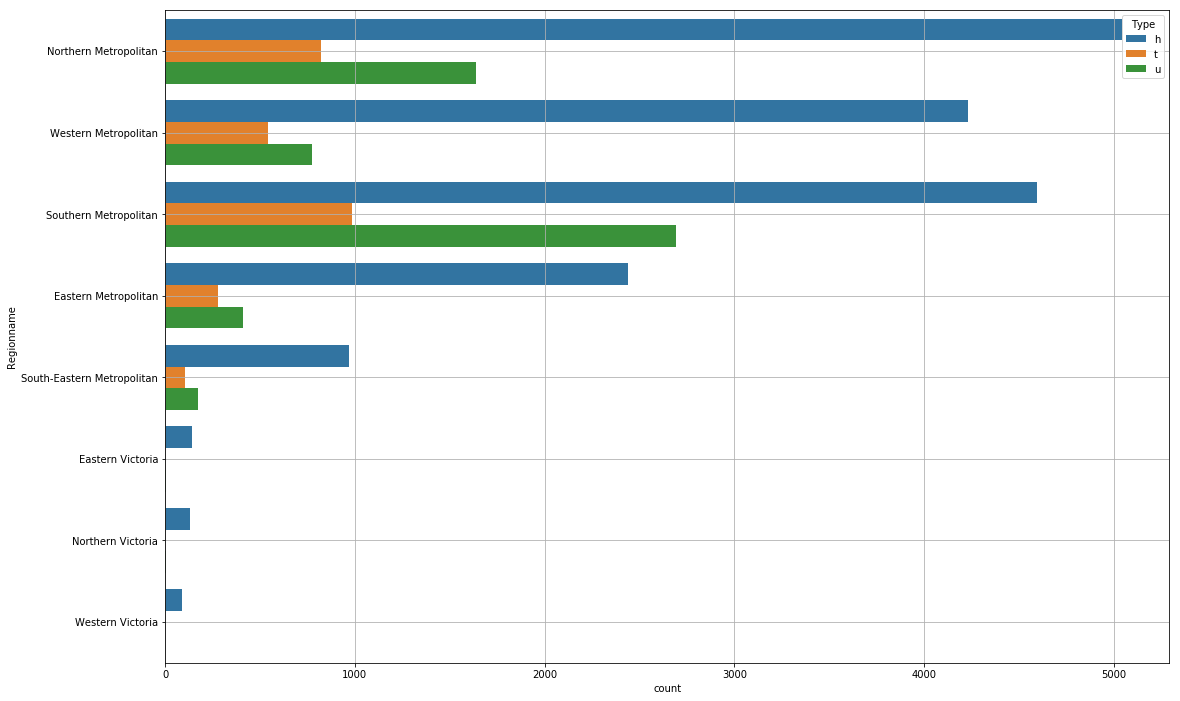

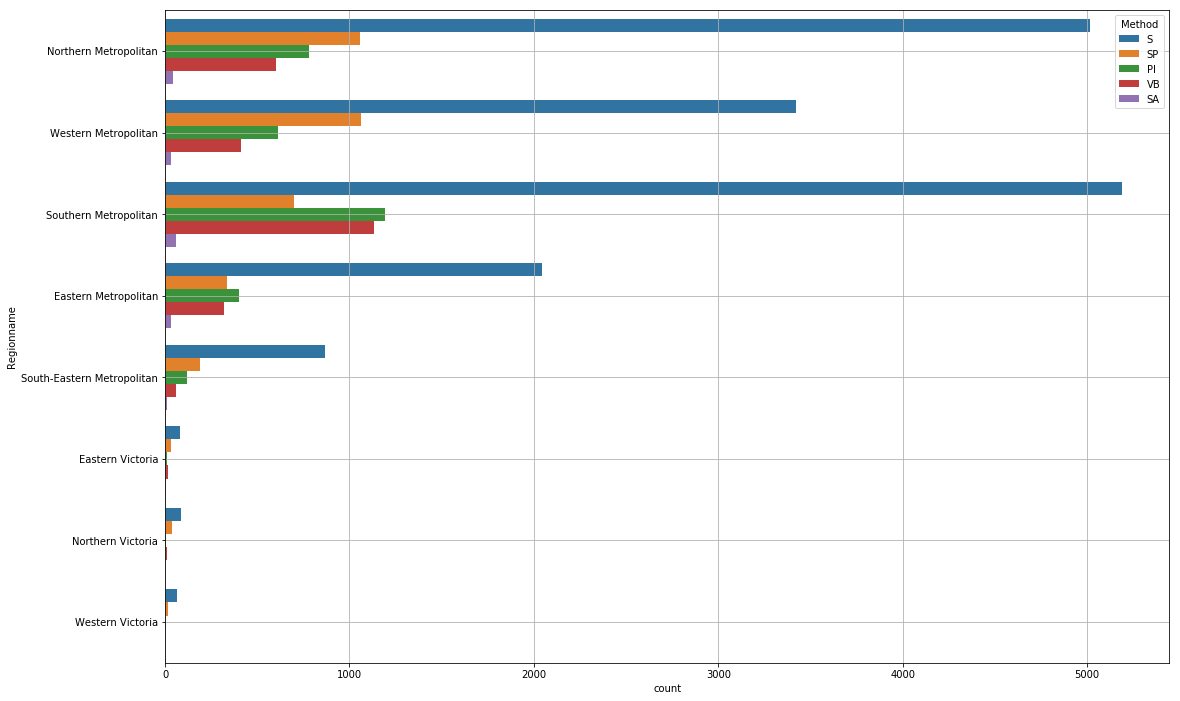

In [88]:
plt.figure(figsize=(18,12))
sns.countplot(data=data, hue='Type', y='Regionname');
plt.grid()

plt.figure(figsize=(18,12))
sns.countplot(data=data, hue='Method', y='Regionname');
plt.grid()

And returning to features numerical lets plot **Prices** distributions grouped by **Rooms, Car, YearBuilt, Bedroom2, Bathroom** and cat. feature ** Type** :

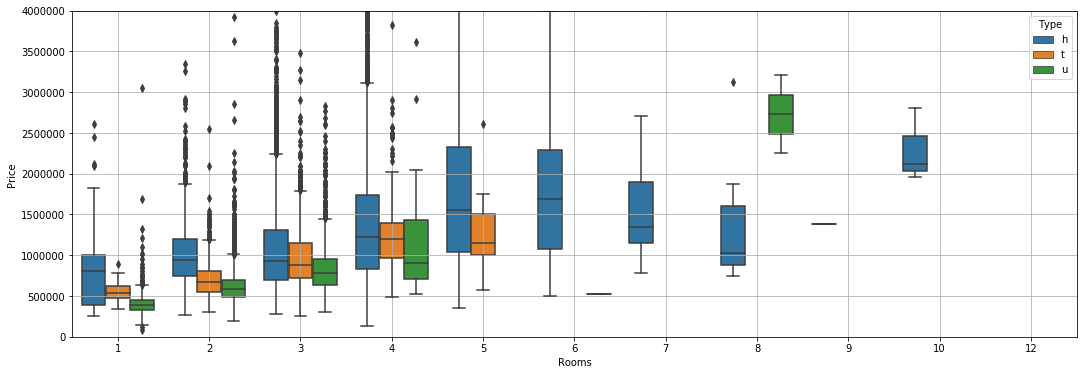

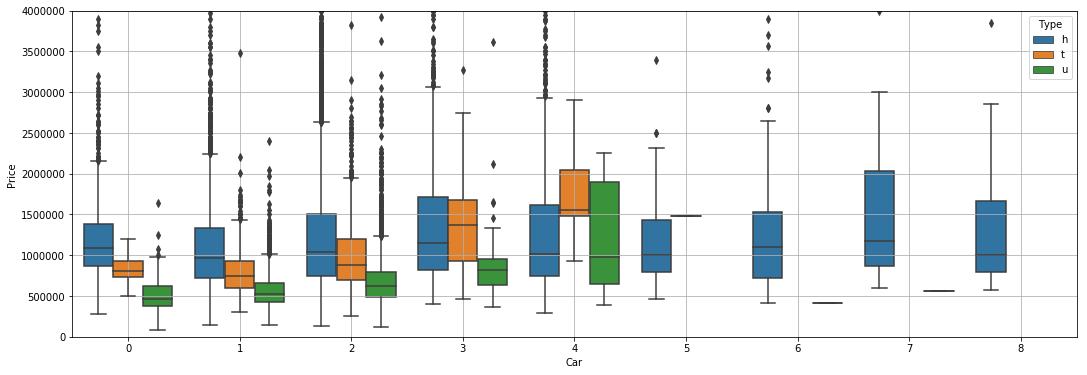

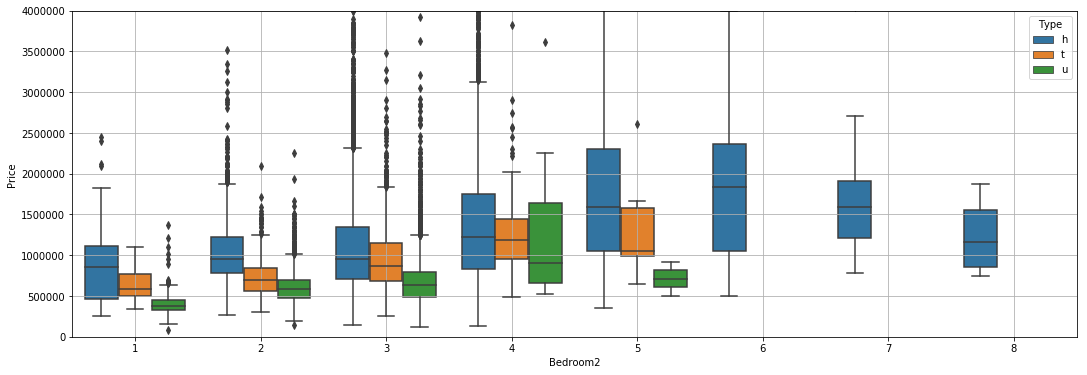

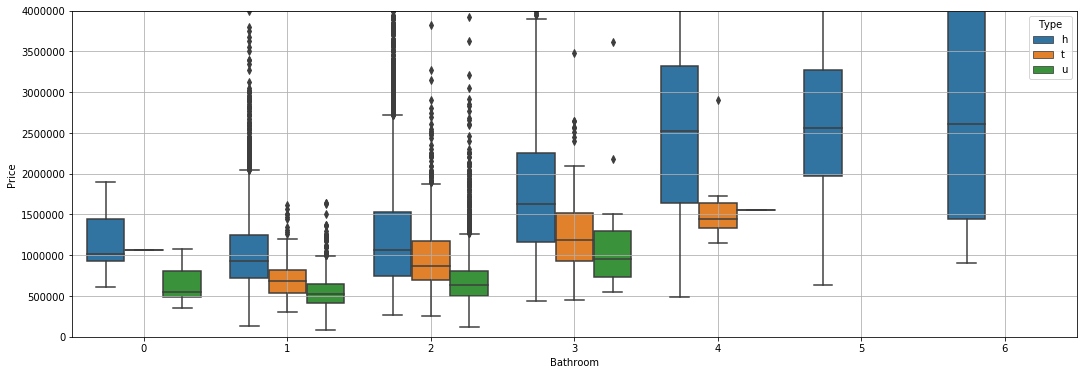

In [89]:
for f in ['Rooms', 'Car', 'Bedroom2', 'Bathroom']:
    plt.figure(figsize=(18,6))
    sns.boxplot(y='Price', x=f,
                hue='Type',
                data=data);
    plt.ylim((0, 0.4*1e7))
    plt.grid()
    plt.show()

Plot **YearBuilt** distributions grouped by **Regionname** and **Type** :

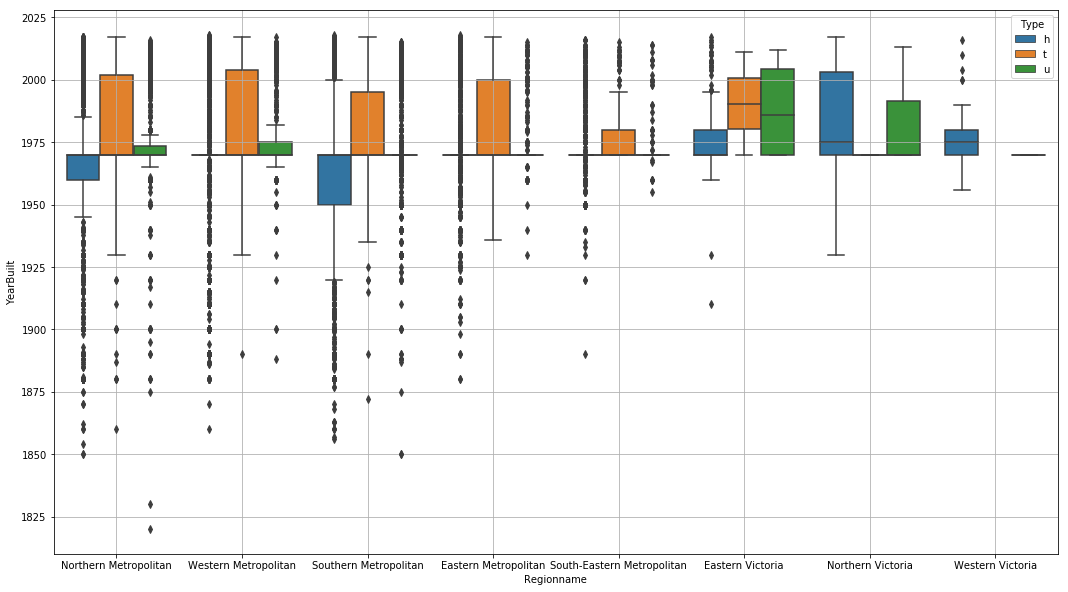

In [90]:
plt.figure(figsize=(18,10))
sns.boxplot(y='YearBuilt', x='Regionname',
            hue='Type',
            data=data);
plt.grid()
plt.show()

Plot **Price** distributions grouped by **YearBuilt** :

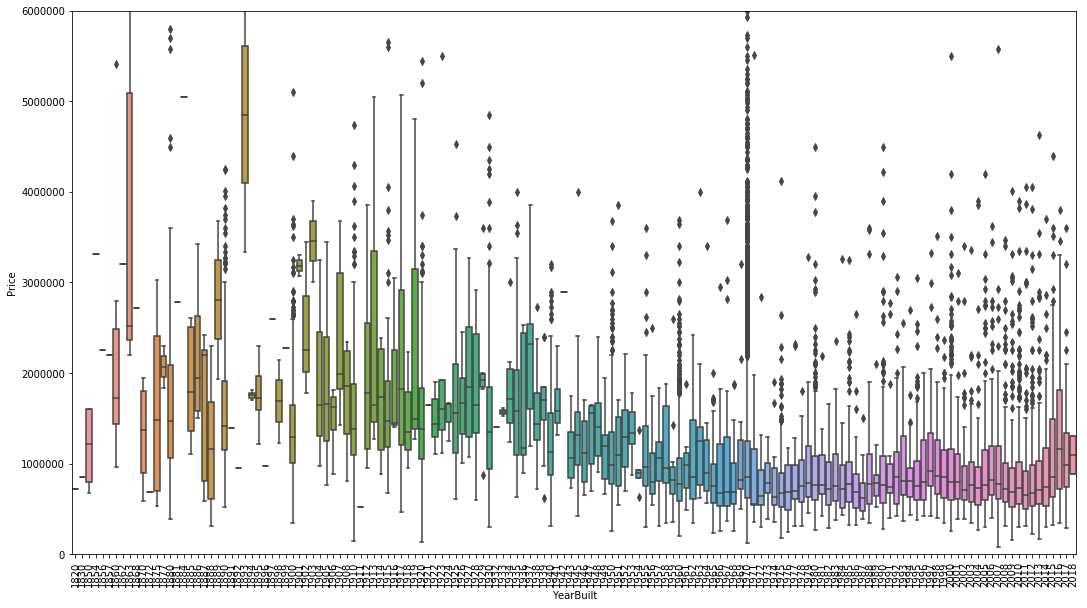

In [91]:
plt.figure(figsize=(18,10))
sns.boxplot(y='Price', x='YearBuilt', data=data);
plt.xticks(rotation=90)
plt.ylim((0, 0.6*1e7))

plt.show()

Average **Price**, grouped by **YearBuilt**

In [92]:
prices_by_yearbuilt = data[['YearBuilt', 'Price']]\
.groupby('YearBuilt')\
.agg(['mean'])

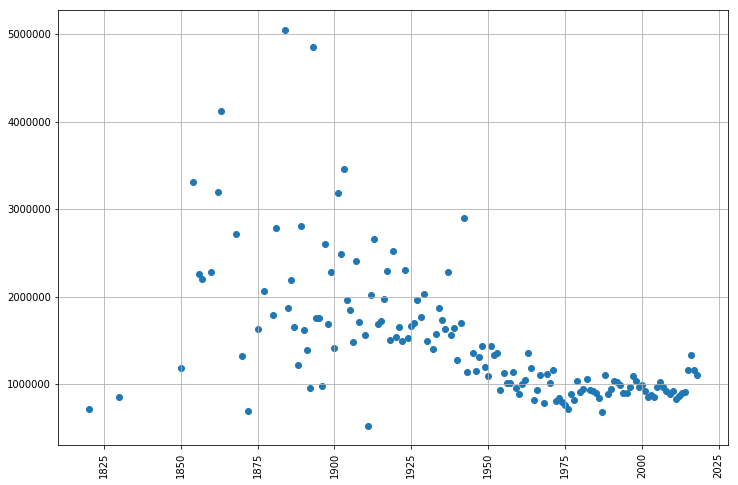

In [93]:
plt.figure(figsize=(12,8))
plt.scatter(x=prices_by_yearbuilt.index,y=prices_by_yearbuilt.values[:,0])
plt.xticks(rotation=90)

plt.grid()
plt.show()

There are *geographical coordinates* in our dataset: features **Longtitude** and **Lattitude** . So we can literally plot a map for some of categorical features! Let's do it for **'Suburb', 'Postcode','CouncilArea', 'Regionname'** and try for **'Distance'**:

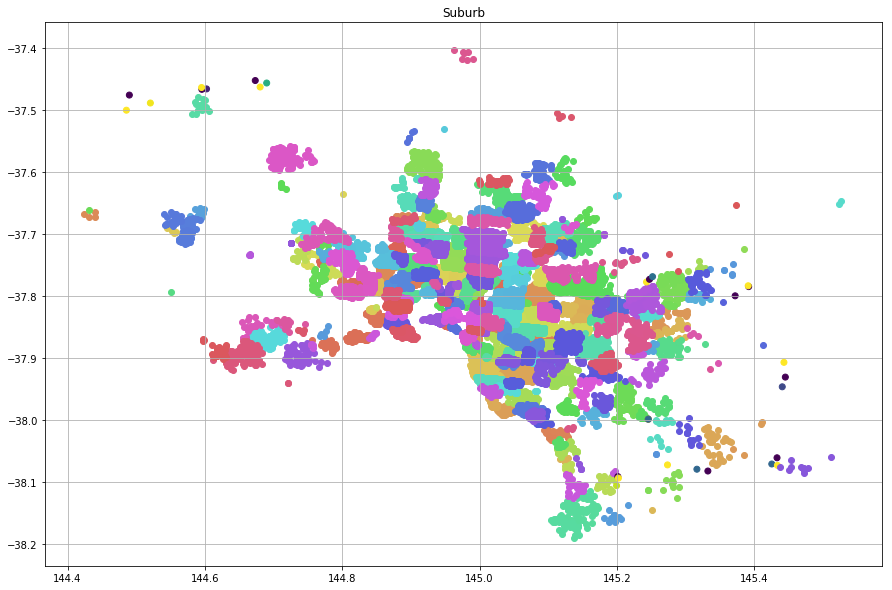

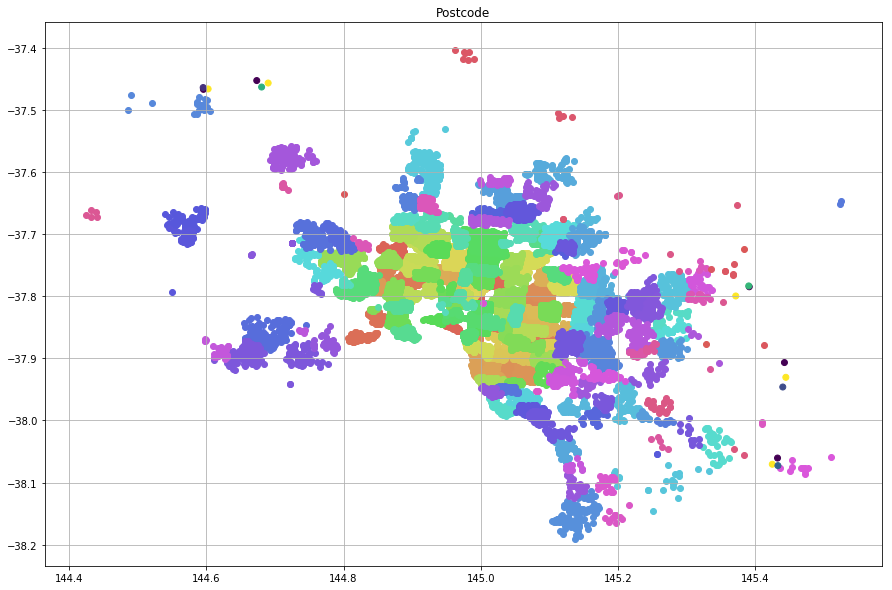

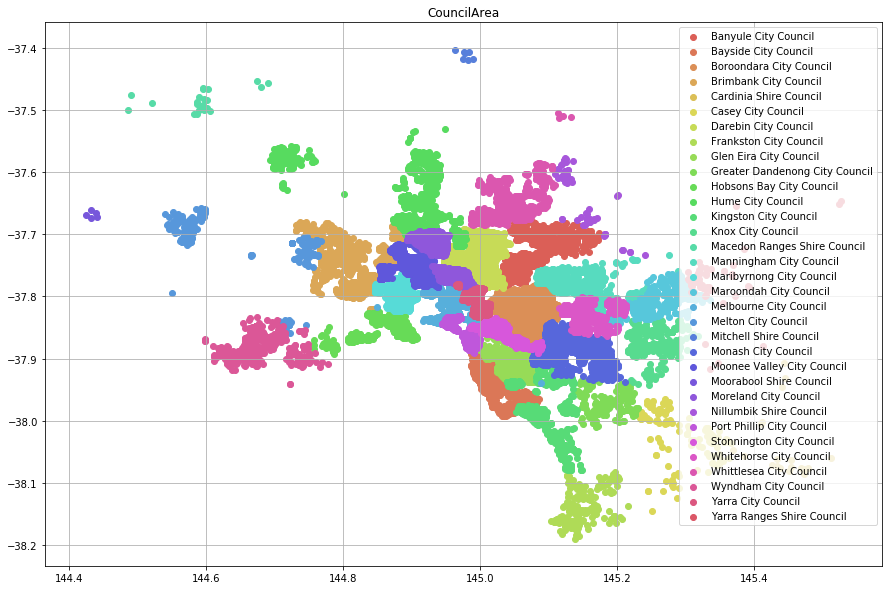

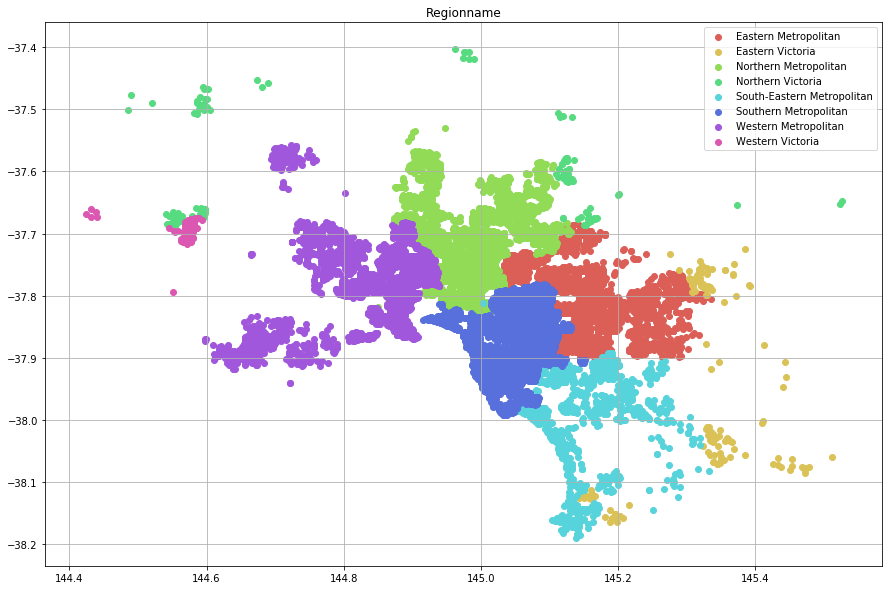

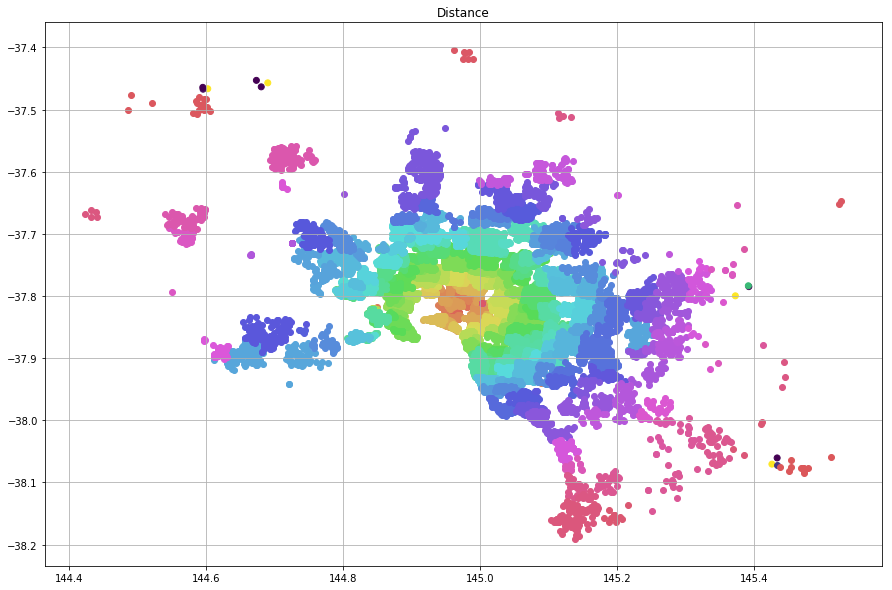

In [94]:
for feature in ['Suburb', 'Postcode','CouncilArea', 'Regionname', 'Distance']:

    plt.figure(figsize=(15,10))
    if feature == 'Postcode':
        feature_unique_values = data[feature].unique()
    else:
        feature_unique_values = sorted(data[feature].unique())
    colors = sns.color_palette("hls", len(feature_unique_values))
    for i, cat_value in enumerate(feature_unique_values):
        plt.scatter(x=data[data[feature] == cat_value]['Longtitude'],
                    y=data[data[feature] == cat_value]['Lattitude'], c=colors[i]);
    
    plt.title(feature)
    if feature in ['CouncilArea', 'Regionname']:
        plt.legend(feature_unique_values);
    plt.grid()
    plt.show()

#### 3.3 Date feature and its relashoinships with target and other features

There is a date of sale in dataset. Let's extract year and month from it and plot prices and sales count, grouped by year and by month:

In [95]:
data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year

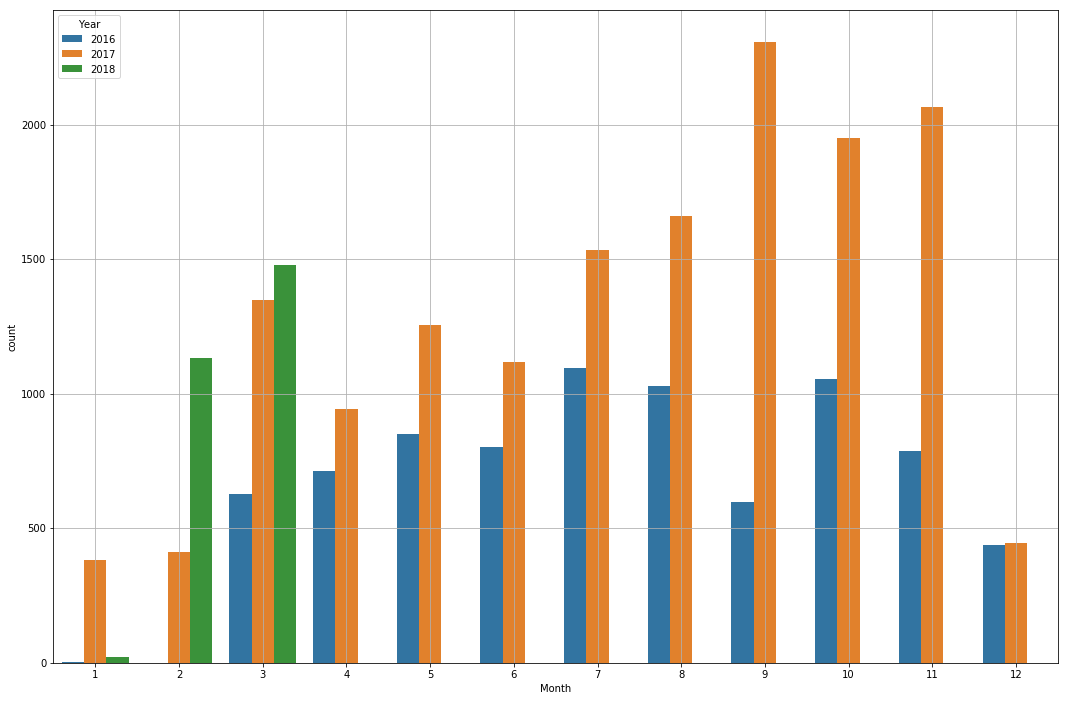

In [96]:
plt.figure(figsize=(18,12))

sns.countplot(x='Month',
              hue='Year',
              data=data);
plt.grid()
plt.show()

### 3.4 Conclusions

Let's resume to our assumptions from **p.2** and add make conclusions about them after visual data analysis :

1. It's evident, that features **Rooms,  Bedroom2, Bathroom, Car, Landsize, BuildingArea**  are directly proportional to house price. Therefore, it is expected that they should have a high correlation with target.
<font color = 'green'> Yes, in general, without grouping by cat. fatures it's true. </font>
 
2. **Date** of sold probably will have seasonal influence on price: for example, there is low season at summer and high season at winter. 
<font color = 'red'> No, there is no seasonality during the year. There is rather **uptrend** during all period in dataset. </font>
 
3. **Distance** from CBD may have complex, non-linear influence on price. On the one hand, the price should be the highest in the center and should decrease when moving to the outskirts. On the other hand, in the centre of big city there is a bad ecology and very noisy. 
<font color = 'red'> No, there is realy mostly linear dependency between **Distance** and **Price**. It's confirmed by pairplot and negative correlation coefficient </font>
  
4. Similar reasoning can be done for the **YearBuilt** of construction. On the one hand, the price should be the highest for the new buildings and houses. On the other hand, very old buildings may be architectural monuments and have historical value, so very old buildings may have very high prices.
<font color = 'green'> Yes, there is really non-linear complex dependency: we can't see linear dependency on pairplot, but there is small negative correlation coefficient in generally.   </font>
 
5. Features **Suburb, Postcode, Regionname** characterize houses locations in the city, and, as consequences, crime situation and transport accessibility. So, theese features and their different combinations should influence on the house price.
<font color = 'green'> Yes, there is really different prices in different regions. But it's rather consequence of **Distance** value. 
 </font>

6. **CouncilArea** may characterize the quality of local goverment work. The degree of well-being is depends on this work and, as consequence, depend a house prices in different areas.
<font color = 'green'> Yes, there is really different prices in different **CouncilArea**. But but just like **Suburb, Postcode, Regionname** it's rather consequence of **Distance** value. 
 </font>
7. **Type** of property certainly matters, because own cottage or villa is more expensive, than duplex with neighbors.
<font color = 'green'> Absolutely right, there is really different prices.
 </font>

In addition, there is also a significant price difference in sales method - feature **Method**.

### Part 4. Patterns, insights, pecularities of data 

Let's sum up conclusions about data, based on previous parts.

1. Houses of different types have significant price differences. So, we'll take in account **Type** feature in our predicttion model.

2. Features, that match physical parameters of houses - **'Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea'** - have a direct influence on price according to principle "the larger the size/count, the more expensive". So, theese features are important.

3. There is mostly linear dependency between **Distance** and **Price**. So, **Distance** is important feature.

4. Features **Suburb, Postcode, Regionname, CouncilArea** characterize houses locations. But, as it was visible on our "maps", **Suburb** and **Postcode** introduse almost the same city divisions, so we don't need both of them. Moreover, they introduse too much detalization and this information can be unuseful in our model unlike features **Regionname, CouncilArea**, so we'll first of all try  **Regionname, CouncilArea** in our model.

5. It was unexpected, but sales method - feature **Method** - really matters, at that, we can observe this influence along all types of houses. So, it will be important information in our model too.

6. Sutuation with **YearBuilt** is not easy. For houses buld before 1950 there is a huge price variance. From 1950 to 2013 average price is much more stable. But new houses, build after 2013 have higher average price. So, this feature is important, but we need to tranform it before addition to our model.

### Part 5. Metrics selection

Prediction price is a **regression** task. In our data **Price** distribution have big skewess coeffitient. This means, that there outliers - very small percent with huge prices in compare with most other objects. Our goal is to build precise model for most objects with usual prices. As mentioned above, for very expensive houses we have to build a separate model. 

So, in current task, priority in the accuracy of the prediction will be given to the main majority of objects. 

A good metric here is **MAE (Mean absolute error)**. In compare with **(R)MSE  (Root mean squared error)**,  **MAE** is less susceptible to large errors on houses with a very large price (fines less for larger errors in absolute magnitude, since only the error modulus is taken, not its square), that сorresponds to the conditions of our task - get the most adequate model metrics for most objects. Big errors on houses with huge price will not distort **MAE** unlike **(R)MSE**.

$$ MAE = \frac{1}{n} \sum_{i=1}^n \mid{y_i - \widehat{y_i}}\mid $$

From an interpretation standpoint, **MAE** is clearly the winner. **(R)MSE** does not describe average error alone and has other implications that are more difficult to tease out and understand. In our task **MAE** have interpretation *"average error in Australian dollars"*. It is very easy to explain such error to every buyer or seller.

### Part 6. Model selection

The most of features in our data, as shown before, have a linear dependency with **Price**. So, this is a good reason to use ***linear regression model*** in our task. Despite of its siplicity, linear models have several advantages in our task:

1. Fitting very fast 
2. Effective with a huge count of features (we have a categorical features with multiple values, so after, for example, one hot encoding, we'll get a hundreds of them)
3. Good interpretation: a feature importance is just a absolute value of its coeffitient in fitted linear model.

We'll use **Lasso regression** from sklearn  module. Lasso has a nice property to select features. Just for comparison, we'll try **Random Forest**.

### Part 7. Data preprocessing

Outliers and missings was processing before in Part 2. So in this part we just divide our data into train and validation sets and make one hot encoding.

#### 7.1 Split data into train and control parts

We have time dependency in our data, so we have to create train and control datasets so, that maximun date in train data is less or equal to minimal data in control data set. So we sort data by date and split it into train and control in proportion 7/3:

In [99]:
data_sorted = data.sort_values(by='Date')
data_sorted.reset_index(inplace=True, drop=True)

In [100]:
X = data_sorted.drop('Price', axis=1)

In [101]:
y = data_sorted['Price']

y.reset_index(inplace=True, drop=True)

In [102]:
split_index = int(0.7*X.shape[0])

X_train = data_sorted.loc[: split_index, :].drop('Price',axis=1)
X_valid = data_sorted.loc[split_index:, :].drop('Price',axis=1)

In [103]:
y_train = y.loc[: split_index]
y_valid = y.loc[split_index:]

In [104]:
# Check sizes of datasets
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((18239, 23), (7817, 23), (18239,), (7817,))

#### 7.2 Make one hot encoding

Instead of sklearn's OneHotEncoder let's use own function, it's more convinient, because of string values are in categorical features (OneHotEncoder works only with integer categorical features).

Let's first of all code cat.features only with small categorical values and drop others. So, let it be our baseline.

In [105]:
def make_one_hot_encoding(X, features):
    X_ohe = pd.get_dummies(data=X, columns=features)
    return X_ohe

In [106]:
#  Cat.features only with small categorical values
ohe_features = ['Type', 'Method', 'CouncilArea', 'Regionname']

X_ohe_train = make_one_hot_encoding(X_train, features=ohe_features)
X_ohe_valid = make_one_hot_encoding(X_valid, features=ohe_features)

In [107]:
X_ohe_train.drop(['Suburb', 'SellerG', 'Date','Postcode','Lattitude', 
            'Longtitude', 'Propertycount', 'Street', 'HouseNumber'], axis=1, inplace=True)

X_ohe_valid.drop(['Suburb', 'SellerG', 'Date','Postcode','Lattitude', 
            'Longtitude', 'Propertycount', 'Street', 'HouseNumber'], axis=1, inplace=True)

In [108]:
X_ohe_train.drop('YearBuilt', axis=1, inplace=True)
X_ohe_valid.drop('YearBuilt', axis=1, inplace=True)

In [109]:
X_ohe_train.shape, X_ohe_valid.shape

((18239, 58), (7817, 58))

#### 7.3 Standatrization, Pipeline

When we use linear model, **it's nesessary to standatrize** our data. Let's use **StandardScaler**:

In [110]:
from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()

It's comfortably to use scaler and model in **Pipeline**:

In [111]:
from sklearn.pipeline import Pipeline

Also, let's define functions for convertion our target into in logarhytm and backwards:

In [112]:
def to_log(y):
    return np.log(1 + y)

In [113]:
def from_log(y):
    return np.exp(y) - 1

### Part 8. Cross-validation and adjustment of model hyperparameters

When using Lasso, the following optimization task is solving:

$$ \sum_{i=1}^l \sum_{j=1}^n (w_j x_{ij} - y_*)^2 + 
\lambda \sum_{j=1}^n \mid{w_j}\mid     \longrightarrow min{{\substack{w}}}
$$

where $\lambda$ is **regularization hyperparameter**. When $\lambda$ is small, weights vector can has large **$l1$-norm**, i.e. high coefficients at our features values $x_{ij}$, and, as consiquence, model will be very unstable (will have **high variance**). And as $\lambda$ is growing, weights  will be zeroing one by one, and model will be more stable, but will have high **bias**. 

So, our task is find optimal $\lambda$, such as will provide the best quality during cross-validation.

In **RandomForest** we'll tune **max_depth** hyperparameter. When it isn't restrict, trees in forest can grow very deep and complex, that can lead to overfitting. 

*The overfitting symptom is small error at train dataset and big error on validation dataset.*

Let's import modules with linear model **Lasso** (we want to make a feature selection) and **RandomForest** - model for control and function for MAE calculation:

In [114]:
from sklearn.metrics import mean_absolute_error as mae

from sklearn.linear_model import Lasso
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline

Create model object, create **Pipeline** to make scaling ant model fitting at the same time.
Note, that we use **TimeSeriesSplit** crossvalidation! 


This will allow to take into account time dependency in our data.

In [115]:
lasso = Lasso(random_state=42)

In [116]:
params_grid = {'lasso__alpha': np.logspace(-4, 4, 10)}

In [117]:
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])

In [199]:
model_grid = GridSearchCV(pipe, 
                          params_grid, 
                          cv=TimeSeriesSplit(max_train_size=None, n_splits=5))

In [200]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_grid.fit(X_ohe_train, to_log(y_train))

CPU times: user 17.7 s, sys: 188 ms, total: 17.9 s
Wall time: 9.06 s


Let's visualize coefficients for our features (I'm using the code from article of lesson 4):

In [366]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(18, 8))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features)+1, coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right");
    plt.xlabel("Feature name")
    plt.ylabel("Feature weight")
    plt.title("LASSO feature importances")
    plt.grid()

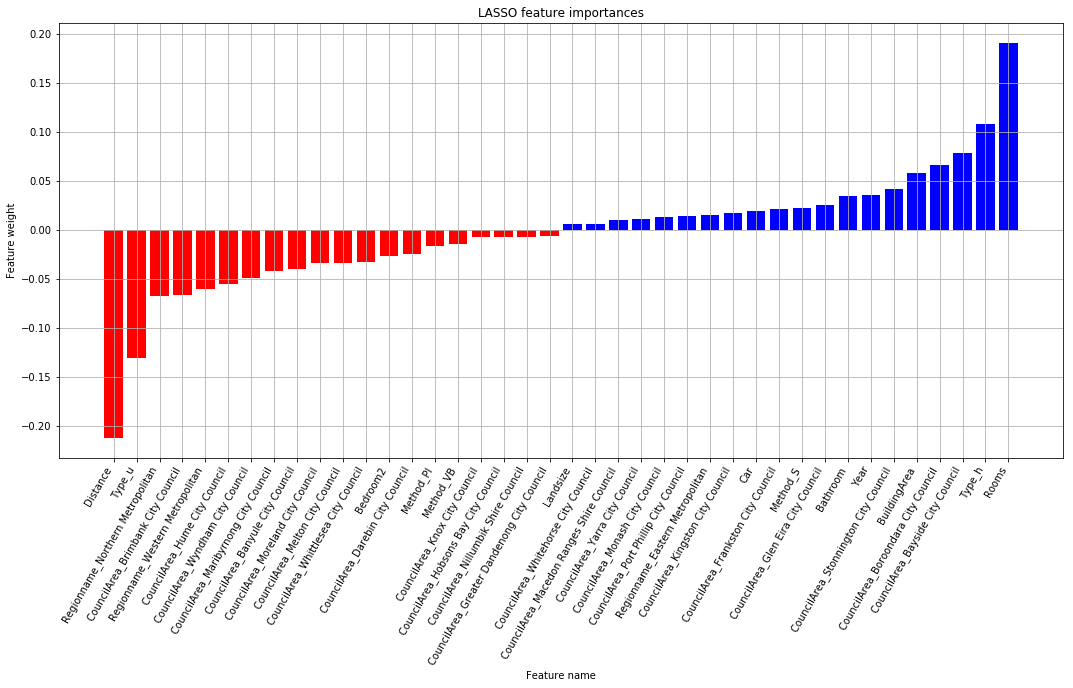

In [367]:
visualize_coefficients(model_grid.best_estimator_.steps[1][1], 
                       X_ohe_train.columns, 
                       n_top_features=20)

Making a predictions on train and validation data:

In [195]:
y_pred_train = from_log(model_grid.predict(X_ohe_train))
y_pred_valid = from_log(model_grid.predict(X_ohe_valid))

Now let's make plot, when every object has x-coordinate $y$ (true value) and y-coordinate $\widehat{y}$ (predicted value), also calculate MAE for train and test datasets and $ \lambda$. It's clearly, that for good model points must locate nearly the diagonal line:

(*Hereinafter we'll make this plot only for objects with prices from 99%-quantile*)


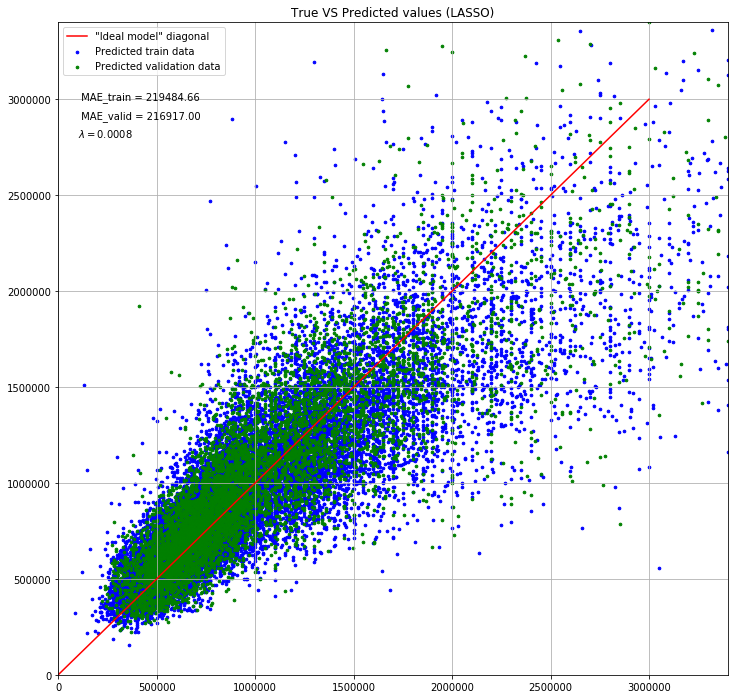

In [376]:
plt.figure(figsize=(12,12))
plt.xlim((0, y.quantile(0.99)))
plt.ylim((0, y.quantile(0.99)))
plt.scatter(y=y_pred_train,  x=y_train, c='blue', s=7)
plt.scatter(y=y_pred_valid,  x=y_valid, c='green', s=7)
plt.plot([0,3e6],[0, 3e6], 'r-')
plt.legend(['"Ideal model" diagonal','Predicted train data','Predicted validation data'])
plt.text(s=" MAE_train = {0:.2f}".format(mae(y_pred_train, y_train)), x=1e5, y=3e6)
plt.text(s=" MAE_valid = {0:.2f}".format(mae(y_pred_valid, y_valid)),  x=1e5, y=2.9e6)
plt.text(s="""$ \\lambda = {0:.4f} $""".format(model_grid.best_estimator_.steps[1][1].alpha), x=1e5, y=2.8e6)
plt.title("True VS Predicted values (LASSO)")
plt.grid()

So, we got $MAE_{train} = 219484$  and $MAE_{valid} = 216917$.

Let's try do better by creation some new features.

### Part 9. Creation of new features and description of this process

Let's create separate datasets to add features to them:

In [126]:
split_index = int(0.7*data.shape[0])

data_sorted = data.sort_values(by='Date')
data_sorted.reset_index(inplace=True, drop=True)

In [127]:
X_train_2 = data_sorted.loc[: split_index, :]
X_valid_2 = data_sorted.loc[split_index:, :]

In [128]:
y_train_2 = X_train_2['Price']
y_valid_2 = X_valid_2['Price']

In [129]:
# Check shapes
X_train_2.shape, X_valid_2 .shape

((18239, 24), (7817, 24))

#### 9.1 Features from YearBuilt

Let's split **YearBuilt** into 3 ranges according differences in average **Price**. We can see it from distributions plot from **part 3.2**. Let's also add a flag for year 1970, because there are a huge count of houses built at that year:

In [130]:
# Year Built

X_train_2['old'], X_train_2['middle'], X_train_2['new'] = 0, 0, 0
X_valid_2['old'], X_valid_2['middle'], X_valid_2['new'] = 0, 0, 0

X_train_2.loc[X_train_2['YearBuilt'] < 1942, 'old'] = 1
X_train_2.loc[(X_train_2['YearBuilt'] >= 1942) & (X_train_2['YearBuilt'] <= 2012), 'middle'] = 1
X_train_2.loc[X_train_2['YearBuilt'] > 2012, 'new'] = 1

X_valid_2.loc[X_valid_2['YearBuilt'] < 1942, 'old'] = 1
X_valid_2.loc[(X_valid_2['YearBuilt'] >= 1942) & (X_valid_2['YearBuilt'] <= 2012), 'middle'] = 1
X_valid_2.loc[X_valid_2['YearBuilt'] > 2012, 'new'] = 1

X_train_2['1970'], X_valid_2['1970'] = 0, 0
X_train_2.loc[X_train_2['YearBuilt'] == 1970, '1970'] = 1
X_valid_2.loc[X_valid_2['YearBuilt'] == 1970, '1970'] = 1

Also, let's calculate  top of the most and the least expensive years of built (sorted by average **Price**). For reliability we'll consider only years with minimum 10 objects built at them: 

In [131]:
count_by_year_built = X_train_2\
                    .groupby('YearBuilt')['Suburb']\
                    .count()\
                    .reset_index()\
                    .rename(columns={'Suburb':'HousesBuiltInYear'})

In [132]:
mean_price_by_year_built = X_train_2.groupby('YearBuilt')['Price'].mean().reset_index()

In [133]:
mean_price_by_year_built = pd.merge(mean_price_by_year_built, 
                                    count_by_year_built, on=['YearBuilt'])

In [135]:
# The most expensive and cheapest houses by YearBuilt

top_year_built_by_price = mean_price_by_year_built\
                            .query("HousesBuiltInYear > 10")\
                            .sort_values(by=['Price'], ascending=False)\
                            .head(10)['YearBuilt']\
                            .tolist()

last_year_built_by_price = mean_price_by_year_built\
                            .query("HousesBuiltInYear > 10")\
                            .sort_values(by=['Price'], ascending=False)\
                            .tail(10)['YearBuilt']\
                            .tolist()

X_train_2['TopYearBuilt'], X_train_2['LastYearBuilt'] = 0, 0
X_valid_2['TopYearBuilt'], X_valid_2['LastYearBuilt'] = 0, 0

X_train_2.loc[X_train_2['YearBuilt'].isin(top_year_built_by_price), 'TopYearBuilt'] = 1
X_valid_2.loc[X_valid_2['YearBuilt'].isin(top_year_built_by_price), 'TopYearBuilt'] = 1

X_train_2.loc[X_train_2['YearBuilt'].isin(last_year_built_by_price), 'LastYearBuilt'] = 1
X_valid_2.loc[X_valid_2['YearBuilt'].isin(last_year_built_by_price), 'LastYearBuilt'] = 1

#### 9.2 Features from Streets

Let's repeat the same procedure as above for **Street**:

In [136]:
# The most expensive and cheapest houses by Streets

price_by_street = X_train_2.groupby('Street')['Price'].mean().reset_index()
count_by_street = X_train_2.groupby('Street')['Suburb'].count().reset_index().rename(columns={'Suburb':'HousesCount'})

price_by_street = pd.merge(price_by_street, count_by_street, on=['Street'])

top_streets = price_by_street\
                .query("HousesCount > 10")\
                .sort_values(by=['Price'], ascending=False)\
                .head(50)['Street']\
                .tolist()

last_streets = price_by_street\
                .query("HousesCount > 10")\
                .sort_values(by=['Price'], ascending=False)\
                .tail(50)['Street']\
                .tolist()

X_train_2['TopStreet'], X_train_2['LastStreet'] = 0, 0
X_valid_2['TopStreet'], X_valid_2['LastStreet'] = 0, 0

X_train_2.loc[X_train_2['Street'].isin(top_streets), 'TopStreet'] = 1
X_valid_2.loc[X_valid_2['Street'].isin(top_streets), 'TopStreet'] = 1

X_train_2.loc[X_train_2['Street'].isin(last_streets), 'LastStreet'] = 1
X_valid_2.loc[X_valid_2['Street'].isin(last_streets), 'LastStreet'] = 1

#### 9.3 One hot encoding for other cat. features and dropping other columns

In [137]:
#  Cat.features
ohe_features_2 = ['Type', 'Method', 'CouncilArea', 'Regionname']

X_ohe_train_2 = make_one_hot_encoding(X_train_2, features=ohe_features_2)
X_ohe_valid_2 = make_one_hot_encoding(X_valid_2, features=ohe_features_2)

In [138]:
X_ohe_train_2.shape, X_ohe_valid_2.shape

((18239, 77), (7817, 77))

In [139]:
cols_to_drop = ['Suburb','Price', 'SellerG', 'Date', 'Postcode','Lattitude', 
                'Longtitude', 'Propertycount', 'Street', 'HouseNumber', 'YearBuilt', 
                'Month', 'Year']

X_ohe_train_2.drop(cols_to_drop, axis=1, inplace=True)
X_ohe_valid_2.drop(cols_to_drop, axis=1, inplace=True)

In [140]:
X_ohe_train_2.shape, X_ohe_valid_2.shape

((18239, 64), (7817, 64))

Let's prepare copy of datasets with new features for RandomForest:

In [141]:
# Save copy for test RandomForestRegressor
X_ohe_train_rf = X_ohe_train_2.copy()
X_ohe_valid_rf = X_ohe_valid_2.copy()

#### 9.4 Polynomial features

While linear regression is just a linear combination of features, **polynomial regression** is very similar, but it allows for a linear combination of features values raised to varying degrees. This fact allows us to create more complex, non-linear models using the same linear models. This trick allows to restore more complex dependencies between features and target value.

Let's try add polynomial features of degree 2 of some of source features:

In [142]:
from sklearn.preprocessing import PolynomialFeatures


features_to_poly = ['Regionname', 'Type', 'Street', 'Method', 'YearBuilt']
cols_to_poly = []
for col_name in X_ohe_train_2.columns:
    for f in features_to_poly:
        if f in col_name:
            cols_to_poly.append(col_name)

poly_generator = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_train_poly_2 = poly_generator.fit_transform(X_ohe_train_2[cols_to_poly])
X_valid_poly_2 = poly_generator.transform(X_ohe_valid_2[cols_to_poly])

X_ohe_train_2 = np.hstack([X_ohe_train_2.drop(cols_to_poly, axis=1), X_train_poly_2])
X_ohe_valid_2 = np.hstack([X_ohe_valid_2.drop(cols_to_poly, axis=1), X_valid_poly_2])

In [143]:
X_ohe_train_2.shape, X_ohe_valid_2.shape

((18239, 254), (7817, 254))

In [144]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
model_grid.fit(X_ohe_train_2, to_log(y_train_2))

CPU times: user 1min 5s, sys: 2.64 s, total: 1min 8s
Wall time: 35 s


Again make predictions on train and valid datasets and plot real and predicted prices:

In [145]:
y_pred_train_2 = from_log(model_grid.predict(X_ohe_train_2))
y_pred_valid_2 = from_log(model_grid.predict(X_ohe_valid_2))

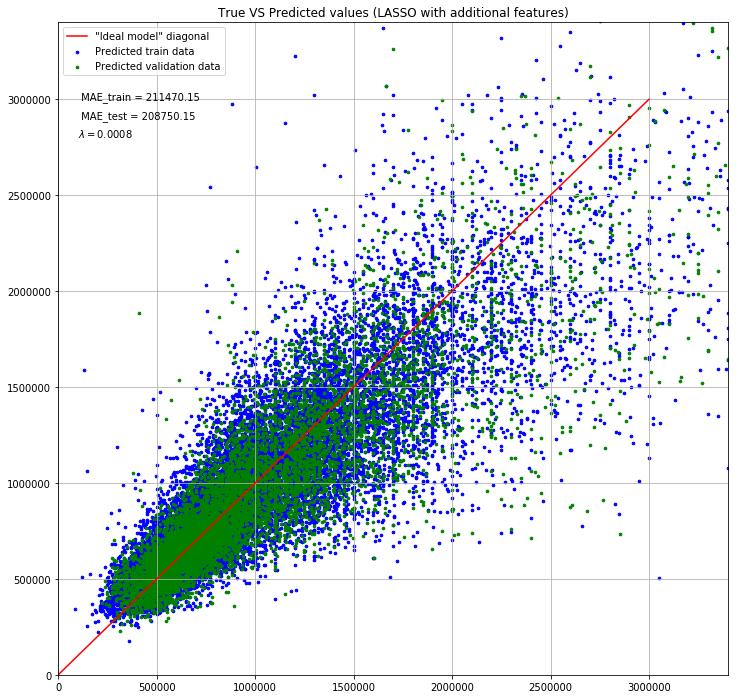

In [377]:
plt.figure(figsize=(12,12))
plt.xlim((0, y.quantile(0.99)))
plt.ylim((0, y.quantile(0.99)))
plt.scatter(y=y_pred_train_2,  x=y_train, c='blue', s=7)
plt.scatter(y=y_pred_valid_2,  x=y_valid, c='green', s=7)
plt.plot([0,3e6],[0, 3e6], 'r-')
plt.legend(['"Ideal model" diagonal','Predicted train data','Predicted validation data'])
plt.text(s=" MAE_train = {0:.2f}".format(mae(y_pred_train_2, y_train)), x=1e5, y=3e6)
plt.text(s=" MAE_test = {0:.2f}".format(mae(y_pred_valid_2, y_valid)),  x=1e5, y=2.9e6)
plt.text(s="""$ \\lambda = {0:.4f} $""".format(model_grid.best_estimator_.steps[1][1].alpha), x=1e5, y=2.8e6)
plt.title("True VS Predicted values (LASSO with additional features)")
plt.grid()

So, now we got $MAE_{train} = 211470$  and $MAE_{valid} = 208750$. 

We see, that error on validation set decresed on **3.8%**

Now, let's try RandomForest with default parameters on the same features (but without polynomial features):

In [184]:
%%time
rf = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_ohe_train_rf, to_log(y_train_2))

CPU times: user 27.9 s, sys: 59.9 ms, total: 27.9 s
Wall time: 28 s


In [185]:
y_pred_train_rf = from_log(rf.predict(X_ohe_train_rf))
y_pred_valid_rf = from_log(rf.predict(X_ohe_valid_rf))

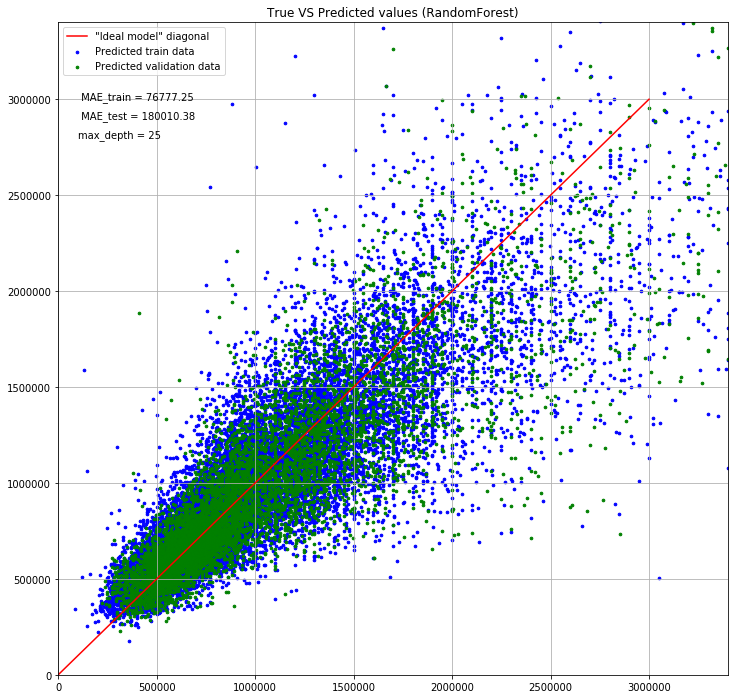

In [384]:
plt.figure(figsize=(12,12))
plt.xlim((0, y.quantile(0.99)))
plt.ylim((0, y.quantile(0.99)))
plt.scatter(y=y_pred_train_2,  x=y_train, c='blue', s=7)
plt.scatter(y=y_pred_valid_2,  x=y_valid, c='green', s=7)
plt.plot([0,3e6],[0, 3e6], 'r-')
plt.legend(['"Ideal model" diagonal','Predicted train data','Predicted validation data'])
plt.text(s=" MAE_train = {0:.2f}".format(mae(y_pred_train_rf, y_train)), x=1e5, y=3e6)
plt.text(s=" MAE_test = {0:.2f}".format(mae(y_pred_valid_rf, y_valid)),  x=1e5, y=2.9e6)
plt.text(s="max_depth = {0} ".format(rf.max_depth), x=1e5, y=2.8e6)
plt.title("True VS Predicted values (RandomForest)")
plt.grid()

We got **overfitted model**, because error on the train dataset is more than twice(!) lower, than error on the validation set.

So, let's try tune hyperparameters of RandomForest using cross-validation to get better quality.

### Part 10. Plotting training and validation curves

We'll provide cross-validation for RandomForest by using **cross_val_score** module with **TimeSeriesSplit** strategy and n_splits=5. Also we'll use our own **scorer** - wrapper for MAE-function to use in cross_val_score-function. Our tuning parametr is **max_depth**.

In [202]:
from sklearn.model_selection import cross_val_score

In [203]:
from sklearn.metrics import make_scorer

# Create scorer with our MAE-function
scorer = make_scorer(mae, greater_is_better=False)

In [213]:
# MAE-function for logarithmic inputs
def mae_score(y_true, y_pred):
    return mae(from_log(y_true), from_log(y_pred))

In [216]:
scorer = make_scorer(mae_score)

In [283]:
# List of params values
max_depth_list = [10, 12, 13, 15, 17, 20, 25]

During cross-validation process for every parameter value our train dataset is splitted into 5 folds: four for model fitting and one for getting cross-validation error. So, we'll get list of of first 4 errors, calculate avarage of them and this will be **'Cross validation MAE on train'** for current max_depth value. Then we'll make a prediction on validation set with the same max_depth value  and calculate **'MAE on validation set'**. Prediction *on full train dataset* (without splitting on folds) will give us  **'MAE on train set'**.

In [286]:
%%time
cv_errors_list = []
train_errors_list = []
valid_errors_list = []

for max_depth in max_depth_list:
    rf = RandomForestRegressor(n_estimators=300, max_depth=max_depth,random_state=42)

    
    cv_errors = cross_val_score(estimator=rf, 
                                  X=X_ohe_train_rf, 
                                  y=to_log(y_train_2), 
                                  scoring=scorer,
                                  cv=TimeSeriesSplit(n_splits=5))  
    cv_errors_list.append(cv_errors.mean())
    
    rf.fit(X=X_ohe_train_rf, y=to_log(y_train_2))
    
    valid_error = mae_score(to_log(y_valid_2), rf.predict(X_ohe_valid_rf))    
    valid_errors_list.append(valid_error)
    
    train_error = mae_score(to_log(y_train_2), rf.predict(X_ohe_train_rf))
    train_errors_list.append(train_error)
    
    print(max_depth)
    

10
12
13
15
17
20
25


Now let's plot dependencies of errors above from **max_depth** parameter:

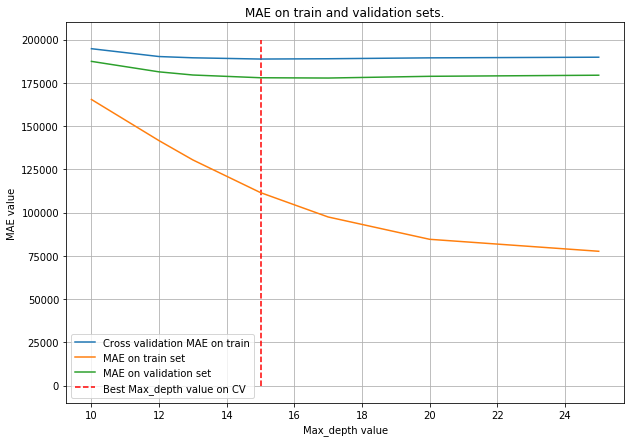

In [320]:
plt.figure(figsize=(10, 7))

plt.plot(max_depth_list,cv_errors_list)
plt.plot(max_depth_list,train_errors_list)
plt.plot(max_depth_list,valid_errors_list)
plt.vlines(x=max_depth_list[np.array(cv_errors_list).argmin()], 
           ymin=0, ymax=2e5, 
           linestyles='dashed', colors='r')

plt.legend(['Cross validation MAE on train', 
            'MAE on train set', 
            'MAE on validation set', 
            'Best Max_depth value on CV'])
plt.title("MAE on train and validation sets.")
plt.xlabel('Max_depth value')
plt.ylabel('MAE value')
plt.grid()

It's clear, that in the begining all errors are decreasing. But after concrete **max_depth** value **'Cross validation MAE on train'** and **'MAE on validation set'** are growing. The minimum value of theese errors is provided by **max_depth**, marked by red dashed line and it's max_depth=15.

In [380]:
best_max_depth

15

Note, that in first RandomForest fitting we got **max_depth = 25**:

In [386]:
rf.max_depth

25

### Part 11. Prediction for test or hold-out samples

Finnaly, let's try to fit RandomForestRegressor with best **max_depth** value, found due to cross-validation. We'll use the same datasets.

In [300]:
rf_best = RandomForestRegressor(n_estimators=300, max_depth=best_max_depth, random_state=42)

In [301]:
rf_best.fit(X_ohe_train_rf, to_log(y_train_2))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

As earlier, let's make a predictions on validation set and plot real and predicted values on train and validation datasets:

In [302]:
y_pred_train_rf_best = from_log(rf_best.predict(X_ohe_train_rf))
y_pred_valid_rf_best = from_log(rf_best.predict(X_ohe_valid_rf))

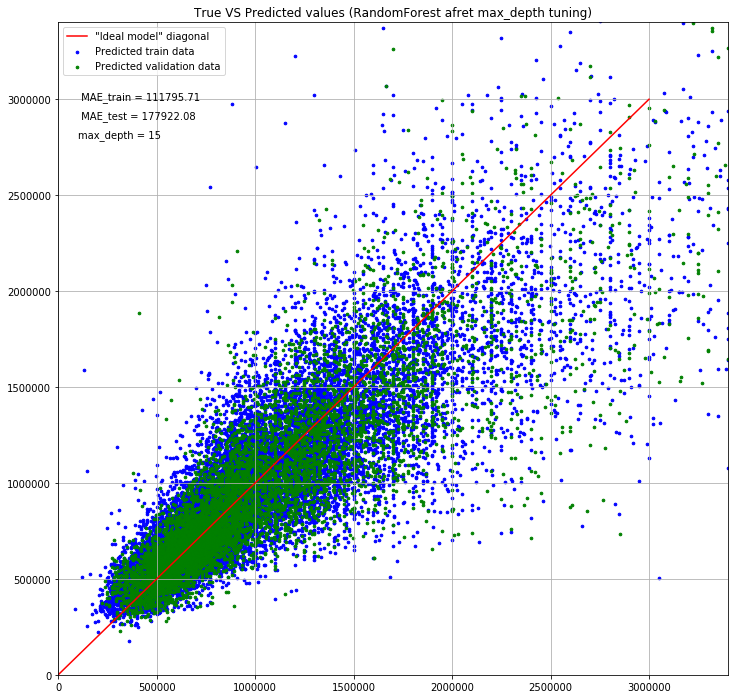

In [385]:
plt.figure(figsize=(12,12))
plt.xlim((0, y.quantile(0.99)))
plt.ylim((0, y.quantile(0.99)))
plt.scatter(y=y_pred_train_2,  x=y_train, c='blue', s=7)
plt.scatter(y=y_pred_valid_2,  x=y_valid, c='green', s=7)
plt.plot([0,3e6],[0, 3e6], 'r-')
plt.legend(['"Ideal model" diagonal','Predicted train data','Predicted validation data'])
plt.text(s=" MAE_train = {0:.2f}".format(mae(y_pred_train_rf_best, y_train)), x=1e5, y=3e6)
plt.text(s=" MAE_test = {0:.2f}".format(mae(y_pred_valid_rf_best, y_valid)),  x=1e5, y=2.9e6)
plt.text(s="max_depth = {0} ".format(rf_best.max_depth), x=1e5, y=2.8e6)
plt.title("True VS Predicted values (RandomForest afret max_depth tuning)")
plt.grid()

So, MAE on train is increased significantly, but MAE on validation is slightly decreased. That mean, that now our model isn't so overfitted as before and has more generalizing ability.

### Part 12. Conclusions

Solution may be useful for **real estate agencies**, who collect such data and try to predict the most adequate prices for properties. It's important, because it allows them to sell/buy properties as soos as possible without money losses and with saving customer loyalty.

Possible cases for model improving is creating more useful features and experiments with other types of models, for example, using as gradient boosting (xgboost, LightGBM, CatBoost)